# Summer Project: Iso-orbital indicator function in RSCAN and PBE
Lennart Gundelach, Oxford 2019

## Load Custom Python Code and Load Data Sets

In [8]:
%run functions.py

Loaded all functions


In [9]:
# load data structure 
with open('./non_mag_paper/data.obj','rb') as myfile:
     non_spin_pol = pickle.load(myfile)

In [10]:
# load data structure 
with open('./ferro_mag_extreme/data.obj','rb') as myfile:
     spin_pol = pickle.load(myfile)

In [11]:
df_non_spin_pol = df_from_dict_2nested(gen_nested_dict_1(non_spin_pol))
df_spin_pol = df_from_dict_2nested(gen_nested_dict_1(spin_pol))

In [12]:
# load data structure 
with open('./ferro_mag_extreme/data.obj','rb') as myfile:
     mag = pickle.load(myfile)

In [13]:
# load data structure 
with open('./ferro_magnetic_PBE/data.obj','rb') as myfile:
     mag_pbe = pickle.load(myfile)

In [14]:
mag_df = gen_df_from_dict(gen_nested_dict(mag,mag_pbe))

In [15]:
# load data structure 
with open('./non_mag_paper/data.obj','rb') as myfile:
     non_mag = pickle.load(myfile)

In [16]:
# load data structure 
with open('./non_mag_PBE/data.obj','rb') as myfile:
     non_mag_pbe = pickle.load(myfile)

In [17]:
non_mag_df = gen_df_from_dict(gen_nested_dict(non_mag,non_mag_pbe))

In [18]:
# load spin data structure 
with open('./ferro_mag_extreme/data.obj','rb') as myfile:
     spin = pickle.load(myfile)
spin.pop('NiO',None)
pass

In [19]:
# load spin_pbe data structure 
with open('./ferro_magnetic_PBE/data.obj','rb') as myfile:
     spin_pbe = pickle.load(myfile)

In [20]:
# load no-spin data
with open('./non_spin_magnetic/data.obj','rb') as myfile:
     no_spin = pickle.load(myfile)

In [21]:
# add no_spin alphas to dictionary
# loop only over intersect
for element in (set(spin.keys()).intersection(no_spin.keys())):
    spin[element]['no_spin']=no_spin[element]['alpha_1']

In [22]:
# turn dictionary into dataFrame
alpha = gen_df_from_dict_new(spin)


## Introduction
The accuracy of Density Functional Theory (DFT) is fundamentally limited by the need to approximate the functional form of the exchange and correlation energies. The most common class of exchange-correlation (XC) functionals are known as general gradient approximations (GGAs) because they use the electron density as well as the gradient of the density. A potential improvement to these GGAs are Metta-GGAs (mGGA) which additionally include the local orbital kinetic energy density. This allows for more flexibility in the form of the functional. 

[SCAN](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.036402) is a promising mGGA functional which aims to minimize the number of free parameters by satisfying all known theoretical constraints on the form of a semi-local functional. These constraints dictate how the functional must behave in the analytically solvable limiting cases. SCAN has consistently outperformed the most common GGA, PBE, on a large variety of systems and is beginning to be more widely utilized . However, implementing SCAN into DFT codes is challenging as it exhibits numerical instabilities. To overcome these instabilities, [Bartok et al](https://aip.scitation.org/doi/10.1063/1.5094646) developed a regularised version of SCAN called RSCAN, which is more numerically stable but maintains the core features of SCAN.

## Iso-orbital indicator function
An important component of both SCAN and RSCAN is the iso-orbital indicator function denoted $\alpha$. Every point in space is assigned an $\alpha$ value which aims to describe the local bonding environment. This information is then used by a switching function, which alters the contributions of terms in the XC functional based on the local bonding environment. In the original SCAN functional, the iso-orbital indicator is defined as,
\begin{equation}
\alpha=\frac{\tau-\tau_w}{\tau_u},
\label{eq1}
\end{equation}
where $\tau$ is the orbital kinetic energy density, $\tau_w$ is the Weizsaecker kinetic energy density and $\tau_u$ is the kinetic energy density of a uniform electron gas given by,
\begin{equation}
\tau_u=\frac{3}{10}(3\pi^2)^{\frac{2}{3}}n^{\frac{5}{3}},
\end{equation}
where $n$ is the electron density. 

In the RSCAN implementation, $\alpha$ is regularized to remove divergence in the very low density regions. This is achieved by adding a small constant to $\tau_u$ and regularizing $\alpha$ via,
\begin{equation}
\alpha'=\frac{\alpha^3}{\alpha^2 + \alpha_r},
\end{equation}
where $\alpha_r$ is a small constant ($1\times 10^{-3}$).

In both implementations, $\alpha$ values fall into three regimes. 

- $\alpha = 0 $: single orbital densities, corrected kinetic energy density much smaller than uniform electron gas
- $\alpha \approx 1 $: slowly varying densities, corrected kinetic energy density similar to uniform electron gas
- $\alpha >> 1 $: non-covalent overlap densities, corrected kinetic energy density much larger than uniform electron gas

The $\alpha$ values of 0 and 1 result from the theoretical constraints on the XC functional. Values of $\alpha$ above 1 are fitted to well-characterized systems. 

There are two separate alpha values for the exchange and correlation portions of the XC functional. In the case of spin-unpolarized systems, the exchange and correlation alpha values are identical. For spin-polarized systems, the exchange functional is evaluated separately for spin up and spin down electron densities. Thus, two exchange alpha values are generated at each gridpoint, one for each spin. The correlation energy does treat spins explicitly, and hence only a single alpha value is generated. The $\alpha$ naming conventions followed in this report are summarized below:

- Spin-unpolarized
  - alpha_1 : Exchange alpha
  - alpha_2 : Correlation alpha
- Spin-polarized
  - alpha_1 : Spin up Exchange
  - alpha_2 : Spin down Exchange
  - alpha_3 : Correlation

## Performance of RSCAN and SCAN on magnetic systems
SCAN and RSCAN outperform PBE on most systems as a shown by [Zhang et al](https://iopscience.iop.org/article/10.1088/1367-2630/aac7f0). However, both SCAN and RSCAN produce inaccurate results for the spin-densities of some magnetic systems, especially bcc iron. In iron, PBE predicts an integrated spin density of 2.16379 $\hbar /2$ while RSCAN significantly overshoots with a value of 2.66474 $\hbar /2$. The experimental value is about 2.12 eV ([Alageri et al](https://www.sciencedirect.com/science/article/abs/pii/S0379677911002268). 

One potential explanation for the bad performance of SCAN and RSCAN on magnetic systems may be that these systems feature a lot of $\alpha$ values in the regime $\alpha>>1$. As this region is only parameterized via a couple of sample systems, the extrapolation of $\alpha$'s in this region may be inaccurate. Thus, SCAN would perform worse on materials with large $\alpha$ values.

The goal of this project is to investigate the $\alpha$ values generate in the RSCAN implementation in CASTEP for a variety of magnetic and non-magnetic systems to understand if the distributions and magnitudes of the $\alpha$'s can explain the bad performance of RSCAN on magnetic systems like bcc iron. 

## Generating and processing of $\alpha$ values 
In the RSCAN implementation in CASTEP, the XC functional is evaluated at each point on a three-dimensional realspace grid which spans the simulation space. The $\alpha$ values are calculated implicitly during this process. Hence, the CASTEP source code was modified to explicitly calculate and output the $\alpha$ values at each point on the numerical grid. Only the $\alpha$ values at the final iteration of the self-consistent calculation are used. 

The $\alpha$ values are written out as an ordered list and must be reconstructed into three-dimensional arrays. This was done using python. The $\alpha$ 3D arrays as well as lists were stored as pickled python objects for easy storage and retrieval. The lists of $\alpha$ values were further transformed into Pandas DataFrame objects.

## Exploring Alpha Frequency Distributions for spin-polarized and non-spin-polarized materials
For each material, each set of $\alpha$'s is a three-dimensional array containing about 50 000 values. A simple approach to quantifying and comparing these data sets is to consider the frequency distributions of $\alpha$ values in each set. These frequency distributions should impart a general impression of the size of alpha values present and their relative frequency. Below, normalized histograms have been plotted for the different materials studied. A gaussian density kernel estimation is performed on each histogram, and the resulting curve plotted on top of the histograms. 

### Non spin-polarized materials

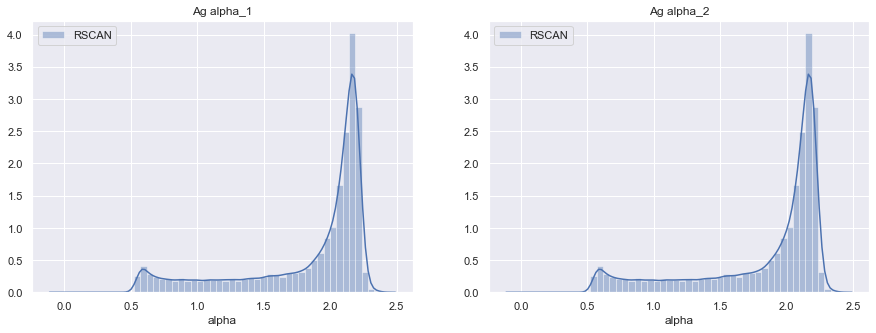

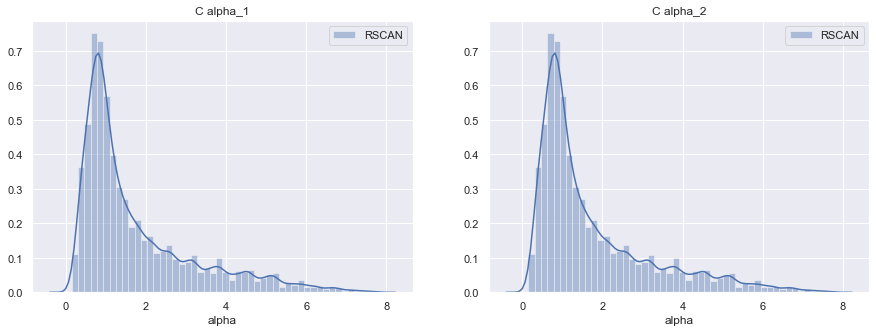

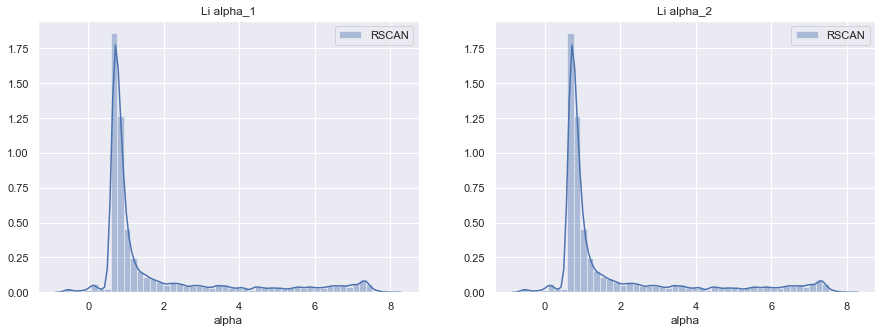

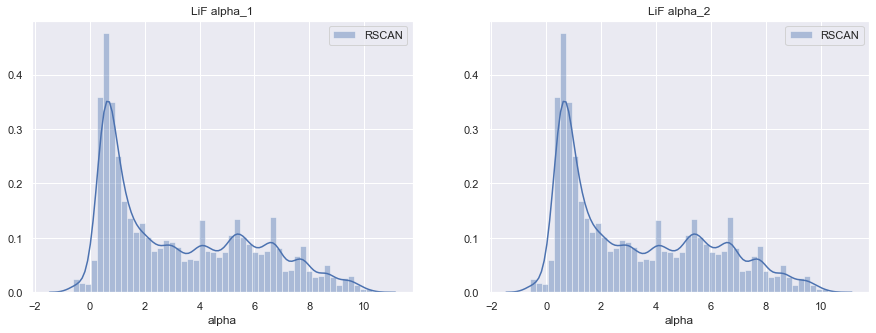

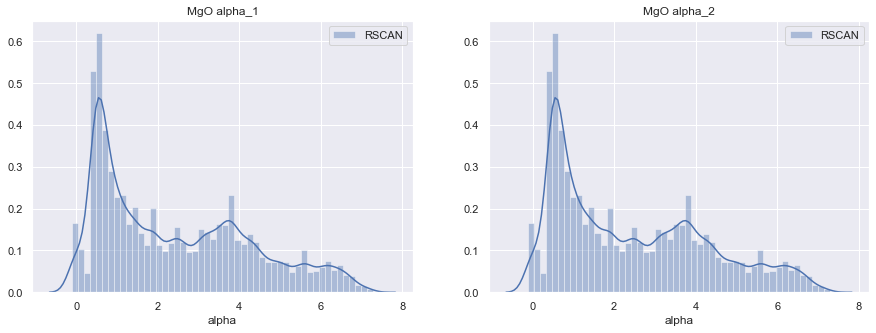

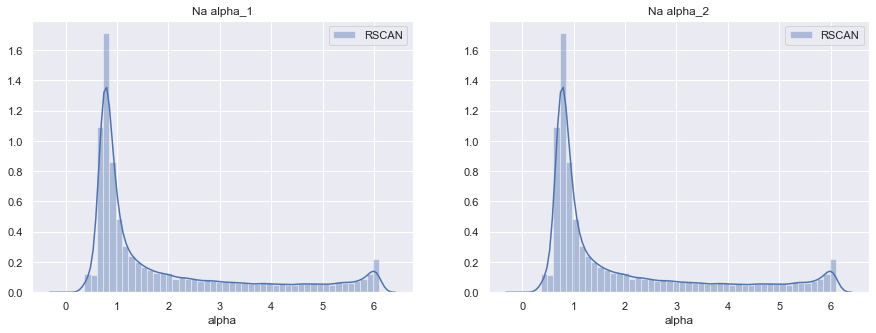

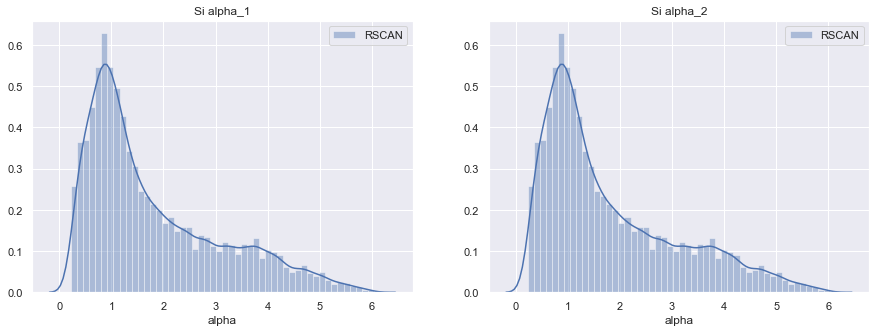

In [26]:
# Generate histograms and KDE lines for all spin-unpolarized systems
for element in df_non_spin_pol.columns.levels[0]:
    histo_alphas(df_non_spin_pol,element,2)

The $\alpha$ frequency distributions for Li and Na are the most similar and exhibit a sharp frequency peak at about $\alpha=1$ and tail off quickly at higher $\alpha$'s. Na and Li have a small, secondary peak at values of 6 and 7, respectively. Li and Na are both good conductors. Si and C (diamond) also have a principal peak at $\alpha=1$ but fall off more gradually and do not have a secondary peak at high $\alpha$. Silicon has a bandgap of about 1.1 eV while diamond has one of about 5.5 eV. LiF and MgO also peak at $\alpha=1$ but have multiple secondary peaks in the region $2<\alpha<6$. Si more closely resembles the shape of LiF and MgO than C. MgO and LiF have larger band gaps than diamond and Silicon, 13.6 and 7.8 eV respectively. In general, it appears that the more insulating the material, the larger the number of $\alpha$'s in the region $2<\alpha<8$. 

The table of summary statistics below confirms that Li and Na are very similar as both their median and average $\alpha$'s are very close. C and Si have higher medians, resulting from the slower fall-off in the region $2<\alpha<6$. LiF and MgO have significantly higher averages and medians due to the secondary peaks in $2<\alpha<6$. 

The frequency distribution of Ag is a complete outlier with the only frequency peak at $\alpha=2.2$. Ag is a metallic conductor. A potential explanation is that the Ag crystal is formed by a different binding type than the other crystals under investigation. 

The summary statistics below show that some of the data sets feature negative $\alpha$ values. Theoretically, this should not be possible, as $\alpha$ is defined to be strictly larger or equal to zero. The likely cause of these negative values are the pseudopotential regions in which the pseudopotentials lead to non-physical potentials close to the atom centers. Analysis of the spatial distribution of $\alpha$'s, later on, will show that these negative values are indeed found in the close vicinity of the atom centers.  



In [84]:
# generate table of summary statistics for spin-unpolarized materials
summary_stats(df_non_spin_pol)

max_a     min_a     ave_a     mea_a
element alpha                                           
Ag      alpha_1   2.378392  0.000000  1.832425  2.075829
        alpha_2   2.378392  0.000000  1.832425  2.075829
C       alpha_1   7.820263  0.000000  1.755098  1.171067
        alpha_2   7.820263  0.000000  1.755098  1.171067
Li      alpha_1   8.043551 -0.620737  1.785894  0.865489
        alpha_2   8.043551 -0.620737  1.785894  0.865489
LiF     alpha_1  10.272779 -0.603214  3.279831  2.487438
        alpha_2  10.272779 -0.603214  3.279831  2.487438
MgO     alpha_1   7.287054 -0.111432  2.416006  1.929229
        alpha_2   7.287054 -0.111432  2.416006  1.929229
Na      alpha_1   6.099838  0.000000  1.895694  1.019766
        alpha_2   6.099838  0.000000  1.895694  1.019766
Si      alpha_1   6.039913  0.225446  1.812754  1.341352
        alpha_2   6.039913  0.225446  1.812754  1.341352

The table below shows the fraction of $\alpha$'s which are larger than 1.0 for the different spin-unpolarized materials. As expected, Ag has the highest percentage, followed by LiF, MgO and then Si and C. These values will be compared to the spin-polarized systems analyzed in the next section. 

In [106]:
print_fractions(df_non_spin_pol,1.0)

alpha_1   alpha_2
Ag   0.887657  0.887657
C    0.577250  0.577250
Li   0.393446  0.393446
LiF  0.695001  0.695001
MgO  0.665727  0.665727
Na   0.510170  0.510170
Si   0.653750  0.653750

### Spin-polarized materials
Below, the same analysis as above is repeated for a set of spin-polarized system. There are now three distinct alpha distributions corresponding to spin up (1) and spin down (2) exchange as well as correlation (3). 

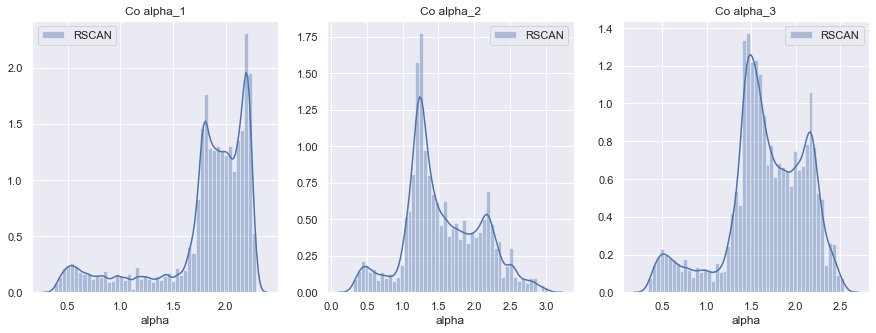

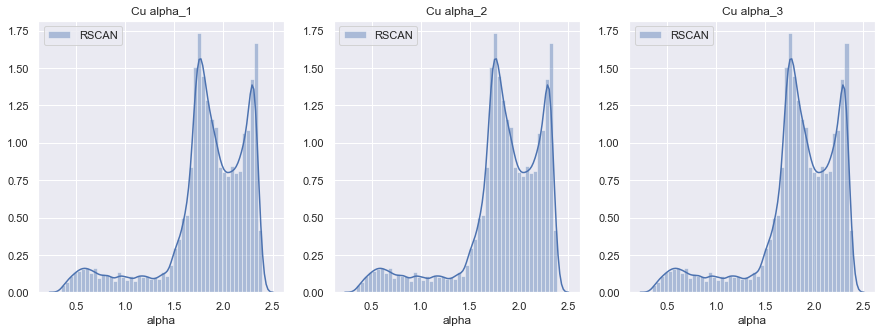

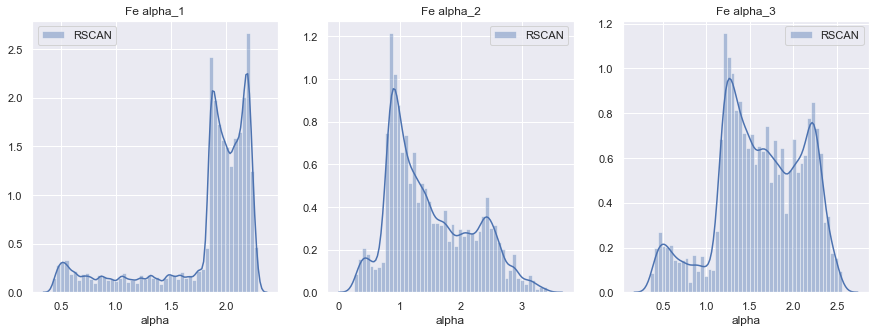

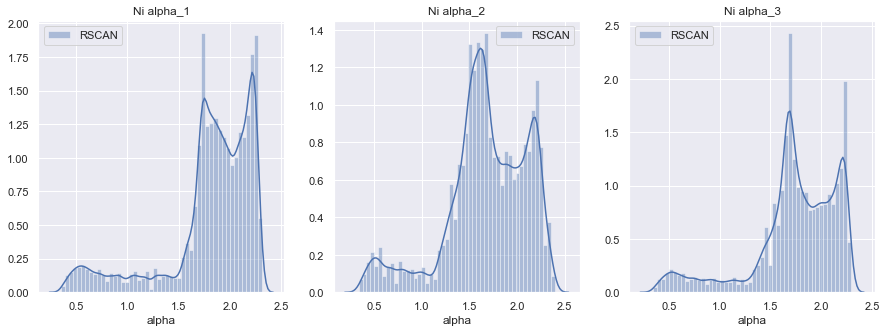

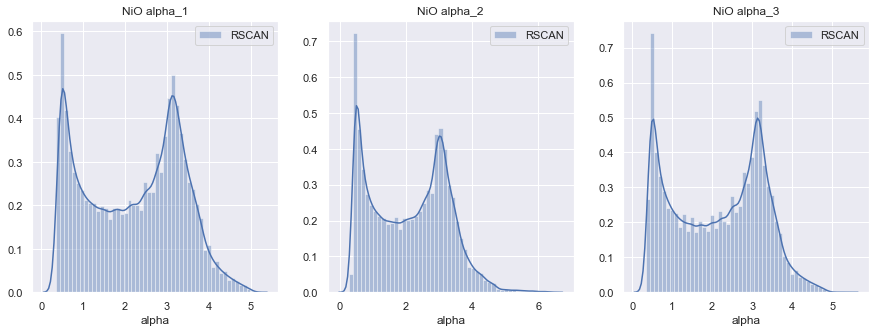

In [40]:
for element in df_spin_pol.columns.levels[0]:
    histo_alphas(df_spin_pol,element,3)

It is immediately clear, that the above systems do not follow the same frequency distributions as the spin-unpolarized systems in the previous section. The spin-up exchange distributions for Co, Cu, Ni and Fe all have a two-pronged peak at about $\alpha=2$, with one prong above, and one below $\alpha=2$. The relative hight of the two prongs differs between the systems, but at all 4 systems exhibit low frequencies for $\alpha<1.5$. NiO also has a two-pronged peak about $\alpha=2$ but the individual prongs peak much farther from $\alpha=2$ at about $\alpha=0.5$ and 3. 

In Cu and NiO, the distributions for all three sets of $\alpha$'s look very similar. In Ni, the two-pronged peak about $\alpha=2$ is maintained for all three sets but the tail below 1.5 differs in shape. For Fe and Co, the two-pronged peak is still present in both spin down exchange and correlation but the lowe prong dominates the distribution in the spin-down exchange $\alpha$'s. For Fe and Co, the three distributions are the most differentiated. From the summary statistics below, we can see that the maximum $\alpha$ values for spin-down exchange in Co and Fe are both above 3 whereas, for the other materials, they are around 2.3, as are those of spin up exchange and correlation. Nonetheless, the averages and medians of the spin-down exchange $\alpha$'s in Fe and Co are lower than those of spin up exchange and correlation. This illustrates that the values for spin-down exchange are more spread, but frequency peaks are lower. 

Interestingly the minimum $\alpha$ values for all of the above systems are about 0.3 compared to the minimum values of 0 observed in the spin-unpolarized systems. Only Si in the spin-unpolarized systems had minimum values of about 2.2. Hence the spin-polarized systems do not have regions corresponding to the single orbital densities regime. 

In [85]:
summary_stats(df_spin_pol)

max_a     min_a     ave_a     mea_a
element alpha                                          
Co      alpha_1  2.286667  0.373544  1.800755  1.922363
        alpha_2  3.029263  0.306909  1.549869  1.426286
        alpha_3  2.536676  0.345099  1.656757  1.650144
Cu      alpha_1  2.389412  0.344239  1.831359  1.876739
        alpha_2  2.389412  0.344239  1.831359  1.876739
        alpha_3  2.389412  0.344239  1.831359  1.876739
Fe      alpha_1  2.287872  0.422851  1.816891  1.964517
        alpha_2  3.417007  0.250320  1.491189  1.316313
        alpha_3  2.557264  0.354411  1.616824  1.615530
Ni      alpha_1  2.308769  0.351289  1.804455  1.894165
        alpha_2  2.397866  0.337373  1.670231  1.672103
        alpha_3  2.295535  0.344759  1.732703  1.765504
NiO     alpha_1  5.083554  0.357540  2.208065  2.370746
        alpha_2  6.432834  0.271641  2.111803  2.203572
        alpha_3  5.346700  0.345773  2.149027  2.287838

The fractions of $\alpha$ values above 1.0 are much higher for the spin-polarized systems and roughly consistent across the three alpha sets. Iron is the only exception to this, with only 69% for spin-down exchange, compared to 89% and 90% for spin-up exchange and correlation respectively. The percentages for Ag in the spin-unpolarized calculations match these results much better, an indication that Ag should have indeed been treated as a spin-polarized system, or that it is chemically more similar to the materials studied here. 

In [107]:
print_fractions(df_spin_pol,1.0)

alpha_1   alpha_2   alpha_3
Co   0.897612  0.906786  0.905328
Cu   0.922734  0.922734  0.922734
Fe   0.892725  0.691401  0.900442
Ni   0.909701  0.914330  0.912787
NiO  0.767780  0.745090  0.757885

### Initial Conclusions
Based on the above results, the hypothesis that magnetic spin-polarized systems sample from large $\alpha$'s compared to other systems cannot be supported. Li and Na display much larger $\alpha$ values than Fe and Co. However, the spin-polarized systems do appear to sample much more from the region $\alpha>1$. Thus, it could be that disproportionally sampling from $\alpha>1$ reduces the accuracy of calculations with RSCAN. 

Furthermore, the differences between the distributions for spin up/down exchange and correlation in Fe and Co should be further investigated, as they may help to explain the poor performance of RSCAN in prediction spin densities for these systems. 

To further test these ideas, the alpha values generated by RSCAN are compared to those generated by PBE.

# RSCAN v.s PBE
To identify if any of the features of the $\alpha$ distributions above could explain the differences in the performance of RSCAN and PBE on metallic spin-polarized systems, the CASTEP code was changed to artificially calculate alpha values in the routines for PBE as well. While PBE does not use the iso-orbital factor in the functional, calculating the values of $\alpha$ that would be generated by PBE may show differences in the way the two functionals treat certain systems. 

## Histogram and Kernal Density Estimate analysis
On the figures below, the histograms for the frequency distributions for the $\alpha$ sets from both RSCAN and PBE are superimposed for comparison. 

### Spin Polarized Materials

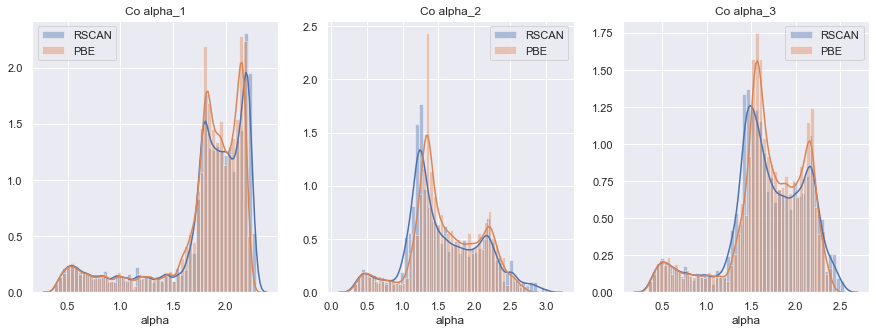

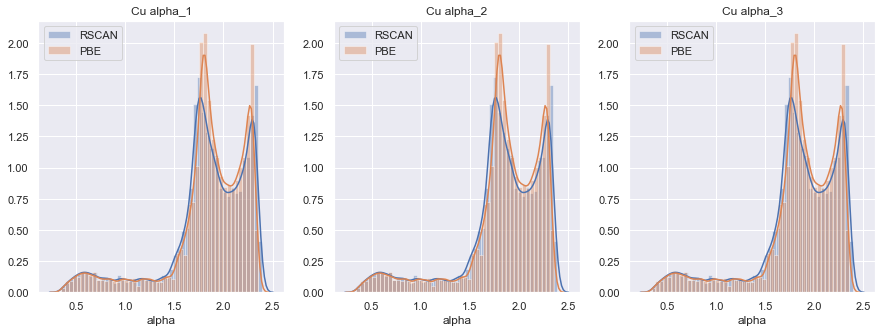

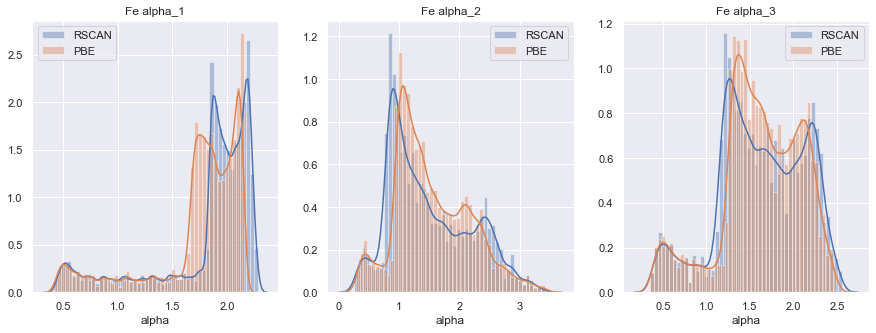

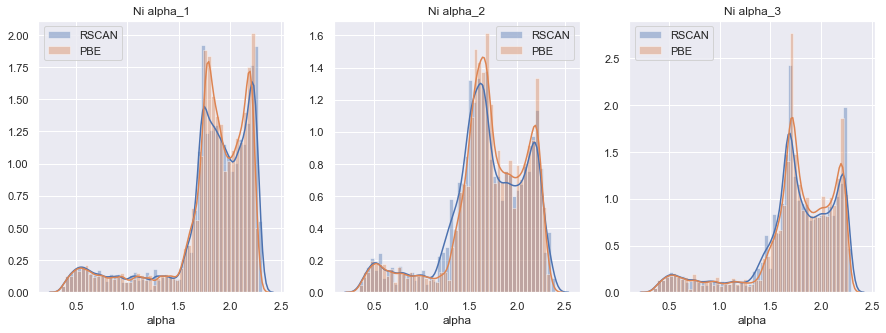

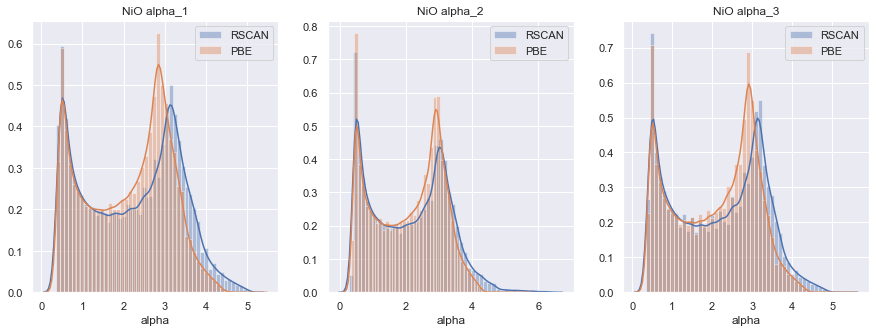

In [137]:
for element in mag_df.columns.levels[0]:
    histo_mega_plot(mag_df,element,3)

### Observations
Overall, the shape of the frequency distributions generated by RSCAN and PBE are very similar. In most of the systems shown above, the frequency peaks in PBE overshoot those of RSCAN. The tails of the distributions in all systems except NiO are indistinguishable. In Ni and Cu the peaks are aligned well and differ only in relative height. In Co and Fe the position of the peaks differs slightly between RSCAN and PBE and this effect is more pronounced in Fe, especially in the exchange $\alpha$'s.

In NiO, the lower peak is well aligned between functionals but the higher peak is not aligned. Furthermore, the high $\alpha$ tail for NiO falls off earlier because the secondary peak for PBE is at lower $\alpha$ values than for RSCAN. 

### Non-spin Materials
As a reference set, the same visual analysis is applied to the spin-unpolrized systems below. 

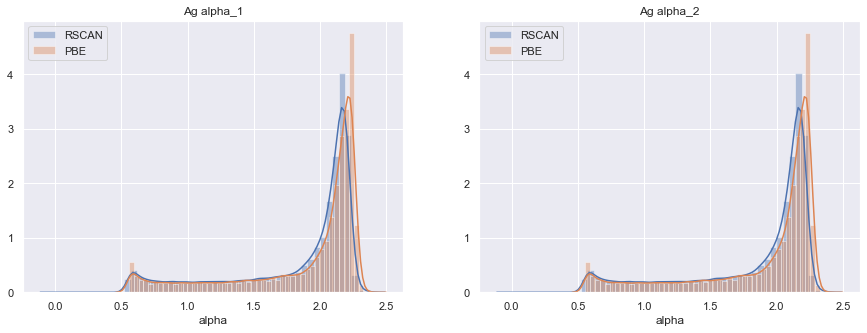

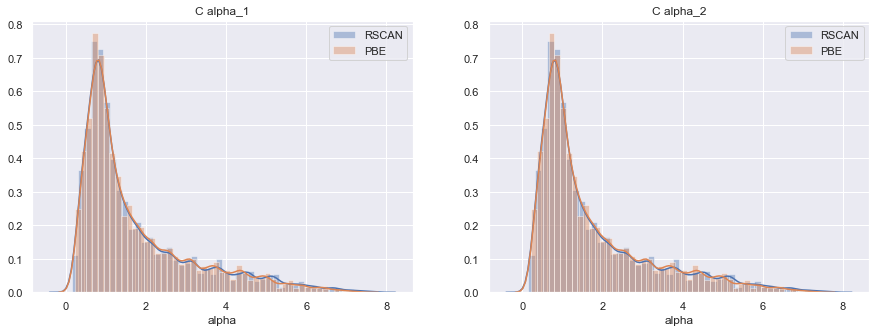

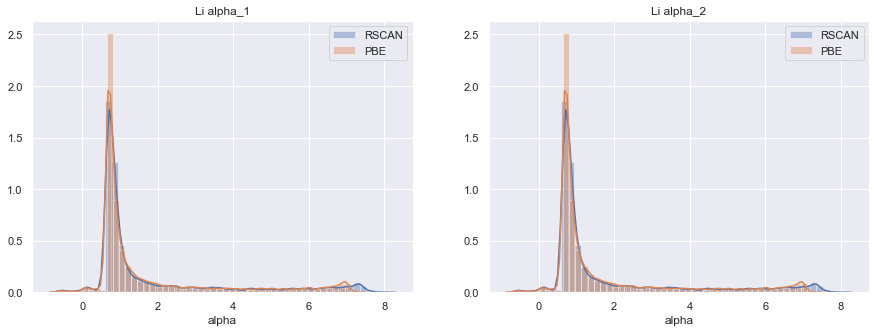

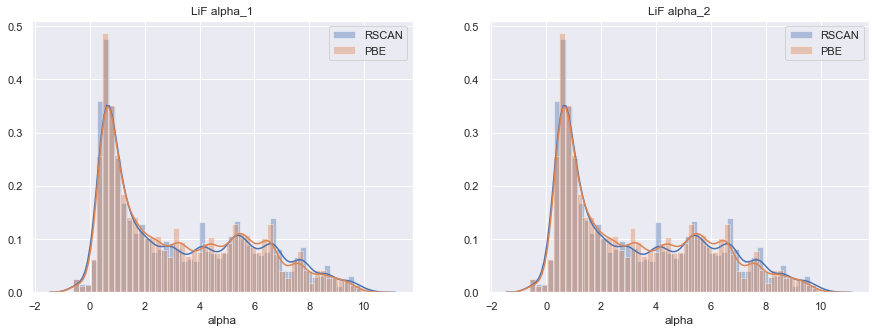

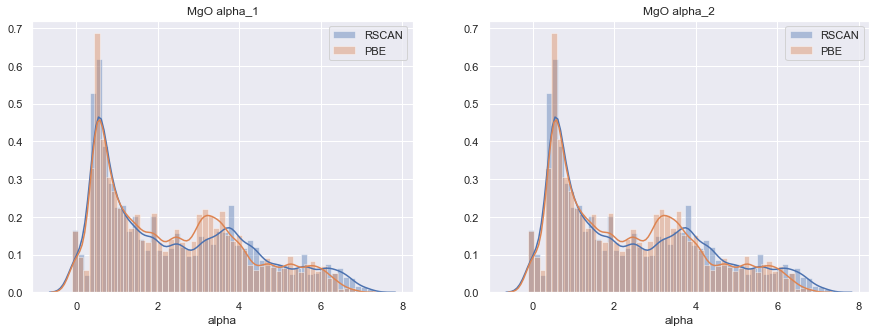

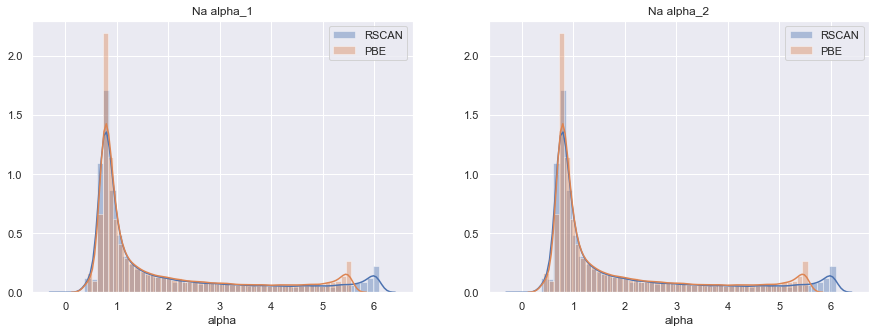

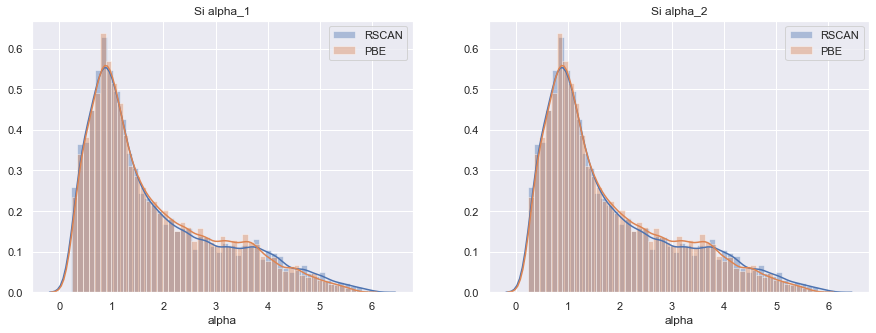

In [138]:
for element in non_mag_df.columns.levels[0]:
    histo_mega_plot(non_mag_df,element,2)

### Observations
Overall, the shape of the frequency distributions is very similar for PBE and RSCAN. PBE seems to have higher frequency peaks in some systems, especially in Na, MgO, Li, and Ag.  In Li, MgO, and Na the high alpha tail of the distribution appears noticeably offset between the two functionals. In Ag, the peaks centered on slightly different alpha values, as observed for the other metal calculations in the earlier figures. By visual inspection alone, it appears that RSCAN and PBE differ more for spin-polarized systems like Fe and Co than for spin-unpolarized systems like Li and C and Si. 

## Statistical Analysis
To compare the PBE and RSCAN $\alpha$ distributions more quantitatively several statistical metrics to describe the similarity of RSACN and PBE alpha frequency distributions are computed below. The Wilcoxen rank-sum test gives the probability (p_wilcox) that the two distributions have the same mean.  The Kolmogorov-Smirnov p-value (p_ks) is the probability that the two sets of $\alpha$'s were drawn from a distribution with the same shape. The intersect is the fraction of the two histograms which overlap and the entropy is a measure of the difference between two distributions, where identical distributions have zero entropy.  

### Spin-pol Materials

p_wilcox      p_ks  intersect   entropy
element alpha                                         
Co      1      0.445766  0.965485   0.929034  0.027876
        2      0.525653  0.999898   0.707412  0.342558
        3      1.000000  0.965485   0.796832  0.143899
Cu      1      0.657847  0.999898   0.894859  0.043939
        2      0.657847  0.999898   0.894859  0.043939
        3      0.657847  0.999898   0.894859  0.043939
Fe      1      0.158990  0.965485   0.833290  0.090513
        2      0.278965  0.770953   0.815501  0.210775
        3      0.313220  0.965485   0.881880  0.105350
Ni      1      0.666014  0.965485   0.966242  0.005730
        2      0.808234  0.965485   0.883702  0.056429
        3      0.910786  0.965485   0.882009  0.051472
NiO     1      0.601213  0.965485   0.844238  0.143333
        2      0.455273  0.770953   0.867615  0.060876
        3      0.519657  0.965485   0.878090  0.075604

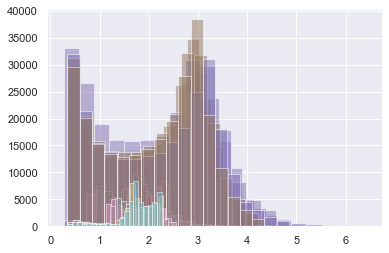

In [153]:
mag_comp = compare_hist(mag,mag_pbe); 
mag_comp

### Observations
All the Kolmogorov-Smirnov p-values are very high, indicating, that the $\alpha$ values for PBE and RSCAN are most likely drawn from distributions of the same shape. The p-values for the Wilcoxon rank-sum test are also all in the range where the null hypothesis that the distribution means are identical cannot be dismissed. 

Based on the extremely low entropy values and high intersects, the $\alpha$ distributions for Ni and Cu from PBE and RSCAN are statistically indistinguishable. The same cannot be said for Fe and Cu. Especially the spin-down exchange $\alpha$'s have higher entropy (>0.2) and lower intersects than the other results. This is in line with the visual analysis above. 

It is important to note that all the metrics calculated above depend on the number of bins used in the histogram analysis. Thus, the values may not be reliable. This is addressed later on in the report. 




### Non-spin Materials

In [38]:
len(non_mag['Na']['alpha_1'][0])

373248

In [39]:
len(non_mag_pbe['Na']['alpha_1'][0])

373248

p_wilcox      p_ks  intersect   entropy
element alpha                                         
Ag      1      0.015240  0.770953   0.692713  0.135893
        2      0.015240  0.770953   0.692713  0.135893
C       1      0.206388  0.999898   0.883375  0.058600
        2      0.206388  0.999898   0.883375  0.058600
Li      1      0.001162  0.002571   0.448384  0.259759
        2      0.001162  0.002571   0.448384  0.259759
LiF     1      0.002067  0.497342   0.812835  0.014747
        2      0.002067  0.497342   0.812835  0.014747
MgO     1      0.695038  0.999898   0.954320  0.008067
        2      0.695038  0.999898   0.954320  0.008067
Na      1      0.033340  0.999898   0.588601  0.580882
        2      0.033340  0.999898   0.588601  0.580882
Si      1      0.247103  0.965485   0.967956  0.003235
        2      0.247103  0.965485   0.967956  0.003235

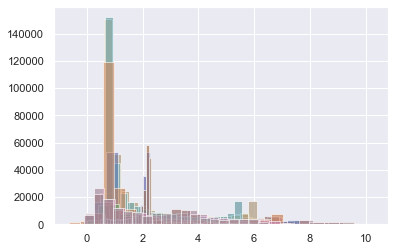

In [152]:
non_mag_comp = compare_hist(non_mag,non_mag_pbe);
non_mag_comp

### Observations
Li and Na have very low p_wilcox and p_ks values, indicating, that the $\alpha$ distributions probably differ between PBE and RSCAN. Given the similar shape but massively large peak at $\alpha=1$, it could be that the total number of $\alpha$ values differs between the PBE and RSCAN calculations. Indeed, the PBE calculation on Li has twice as many values, indicating that a realspace grid twice as fine was used in the calculation. Upon further investigation, this happened because the RSCAN calculation was incorrectly run at a lower precision than the PBE calculation. All of the other systems were run with the same settings and the numbers of $\alpha$'s match for PBE and RSCAN. 

The low overlap and high entropy for Na must be due to the difference in the location the tail peak. RSCAN places this peak at about $\alpha=6$ whereas PBE places it at $\alpha=5.5$. 

# Spin vs.no-spin in metals
Based on the above results, the $\alpha$ distributions in Fe and Co vary more between spin up/down exchange and correlation than for the other systems. Furthermore, PBE and RSCAN appear to differ more in Fe and Co than the other systems (except Na). Thus, we now compare the $\alpha$ distributions generated by calculation on spin-polarized systems for an RSCAN spin-polarized calculation with non-spin-polarized calculations on the same systems. 

## Histogram Analysis
Plot Histograms of spin-polarized and no-spin $\alpha$ sets. 

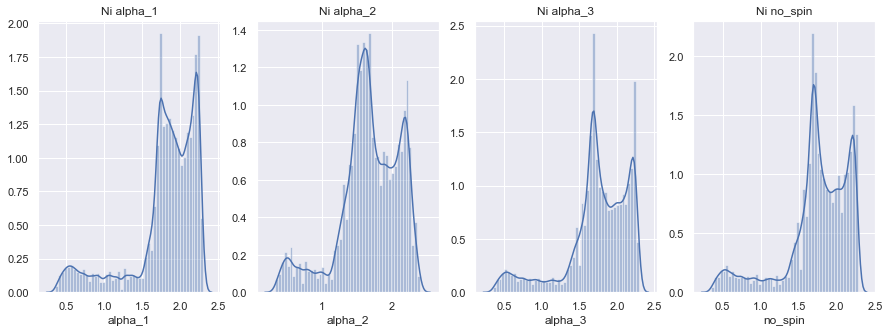

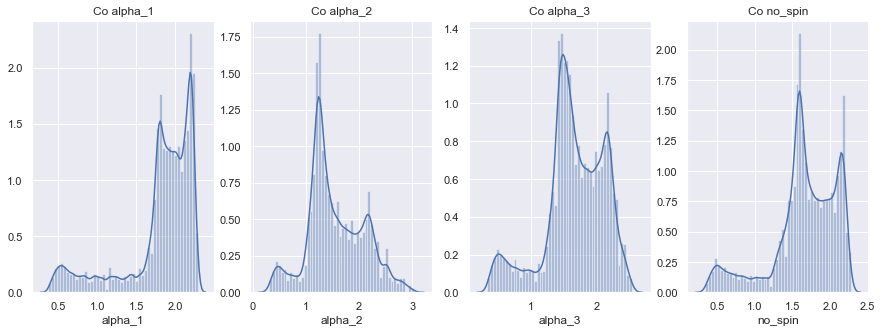

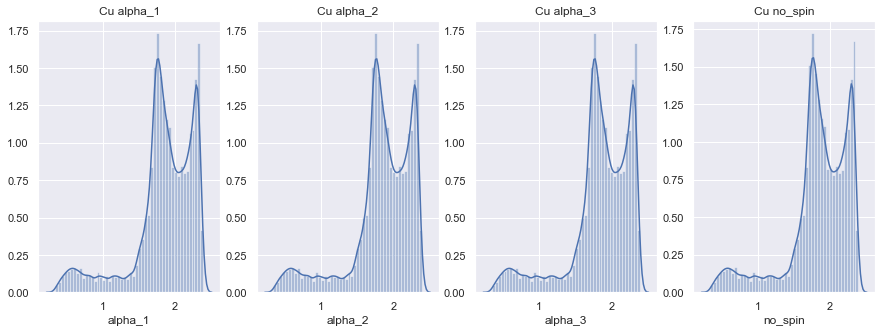

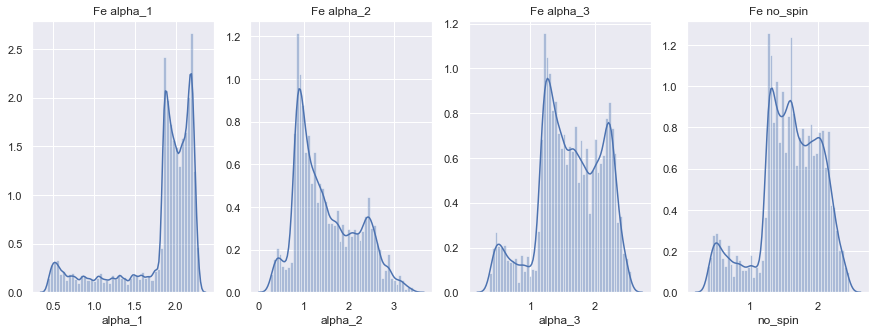

In [162]:
for element in set(spin.keys()).intersection(no_spin.keys()):
    histo_mega_plot_new(alpha,element)

### Overlay spin to no_spin
Re plot histograms but overlay the non-spin histogram over the three spin-polarized histograms.

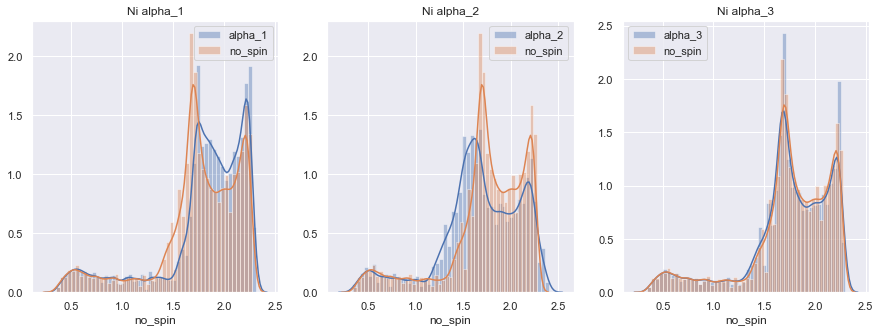

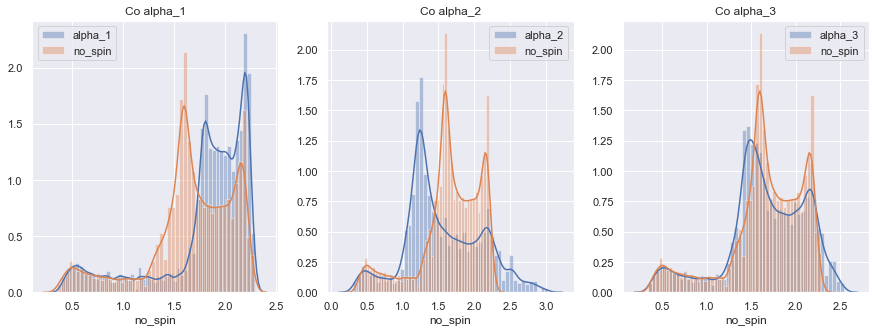

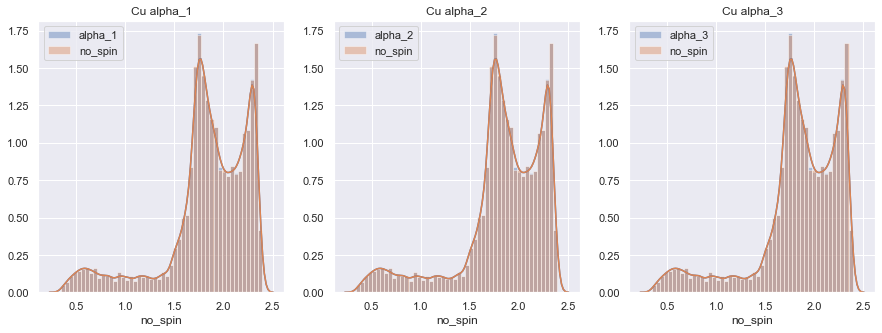

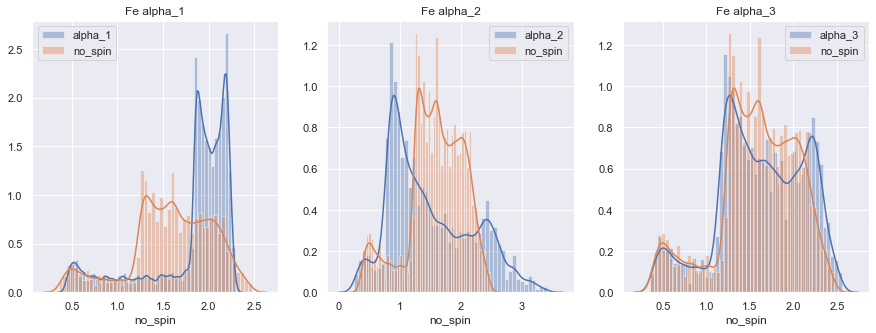

In [163]:
for element in set(spin.keys()).intersection(no_spin.keys()):
    histo_mega_plot_2(alpha,element)

### Observations
For all of the metals, the correlation $\alpha$ distributions look the most similar to no_spin distributions. It appears that for the spin-polarized calculations, the correlation $\alpha$'s most closely resemble the $\alpha$'s generated during a non-spin calculation. In Cu, there appears to be almost no difference in any of the $\alpha$ sets. This may indicate, that spins do not play an important role in this system. In Ni, the no-spin and spin-correlation $\alpha$'s are almost identical. As discussed before, for Ni, the shapes of the exchange distributions also follow a similar pattern to the correlation, and thus the no-spin calculation. 

In Fe, the difference between up/down spin exchange to the non-spin calculation is the most pronounced. For the spin-up exchange, the peak in frequency at $\alpha=2$ is very high and narrow compared to the more spread out peak of the non-spin calculation. 

## Statistical Analysis
Again, apply the same statistical tests to compare how close the spin-pol $\alpha$'s are to the non-spin $\alpha$'s in each material.

p_wilcox      p_ks  intersect   entropy
element alpha                                           
Co      alpha_1  0.600834  0.497342   0.684006  0.293636
        alpha_2  0.681322  0.770953   0.493549  1.008540
        alpha_3  0.779463  0.965485   0.707583  0.311320
Cu      alpha_1  1.000000  1.000000   0.997750  0.000058
        alpha_2  1.000000  1.000000   0.997750  0.000058
        alpha_3  1.000000  1.000000   0.997750  0.000058
Fe      alpha_1  0.793839  0.275269   0.477559  0.798382
        alpha_2  0.667659  0.497342   0.536544  0.799945
        alpha_3  0.375980  0.497342   0.863297  0.132992
Ni      alpha_1  0.481151  0.965485   0.868913  0.060189
        alpha_2  0.903898  0.770953   0.704668  0.302308
        alpha_3  0.670066  0.999898   0.927598  0.016266

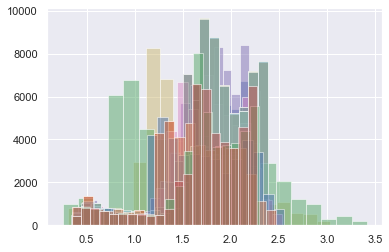

In [168]:
import warnings
warnings.filterwarnings('ignore')
comp_df = compare_hist_new(alpha,bins=20)
comp_df

### Observations 
All of the metrics confirm that for Cu, all the alpha distributions are essentially identical. 
For all materials, except Cu, the overlap between the spin correlation $\alpha$ and no-spin is the largest, and the entropy is the lowest. This indicates that these distributions are the most similar. For Fe, the spin-up exchange $\alpha$'s have the lowest overlap. For Co, spin-up/down exchange also differ significantly from no-spin. 

### Intermediate Conclusions
Based on the results so far, it appears that iron and cobalt are most strongly affected by spin-effects and are most sensitive to the change of functional from PBE to RSCAN. Specifically the behavior of spin-up/down exchange $\alpha$'s warrants further investigation. In an attempt to better understand the behavior of $\alpha$ in iron, the spatial distribution is analyzed next. 

### Side Note: Effect of changing number of bins

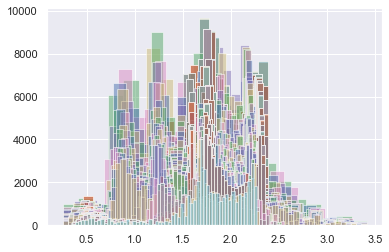

In [171]:
# generate statistical metrics for different number of histogram bins
list_of_df = []
for bins in range(20,60,2):
    temp_df = compare_hist_new(alpha,bins=bins)
    list_of_df.append(temp_df)

In [172]:
# reformat above data into df for each metric and each alpha
metric_dict_list = []
for alpha in ['alpha_1','alpha_2','alpha_3']:
    metric_dict = {}
    for metric in ['p_wilcox', 'p_ks','intersect','entropy']:   
        temp_dict = {}
        for element in ['Co','Fe','Ni','Cu']:
            temp_list = []
            for df in list_of_df:
                temp_list.append(df.loc[element,metric].loc[alpha])
            temp_dict[element]=temp_list/max(temp_list)

        temp_df = pd.DataFrame.from_dict(temp_dict)
        temp_df['bins']=range(20,60,2)
        #temp_df= temp_df.set_index('bins')
        metric_dict[metric]=temp_df
    metric_dict_list.append(metric_dict)

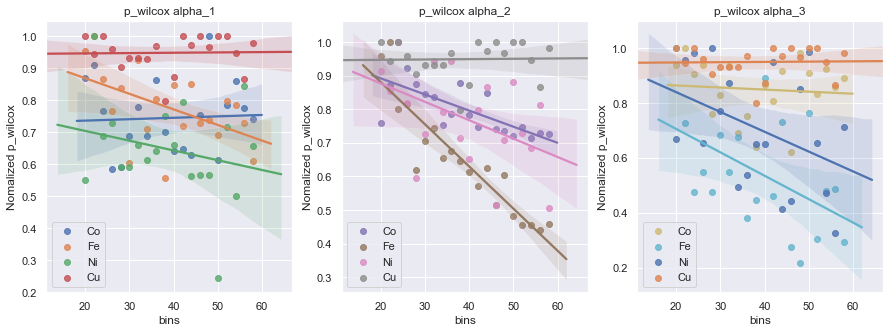

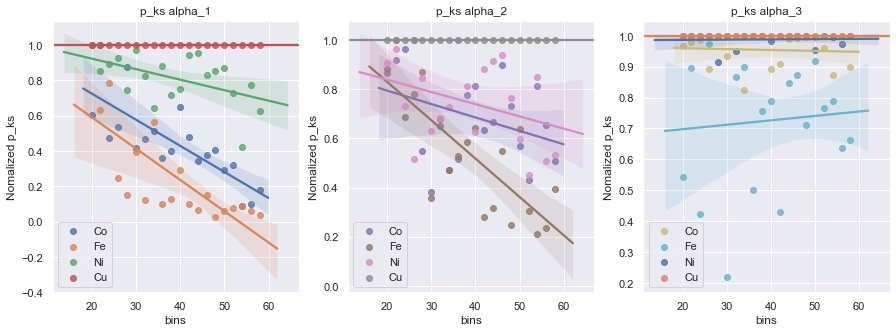

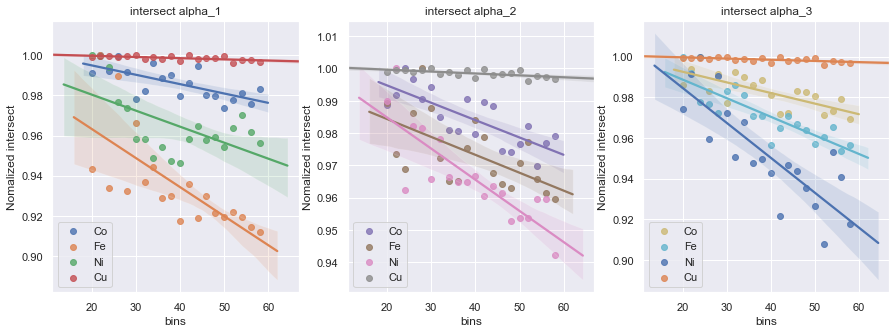

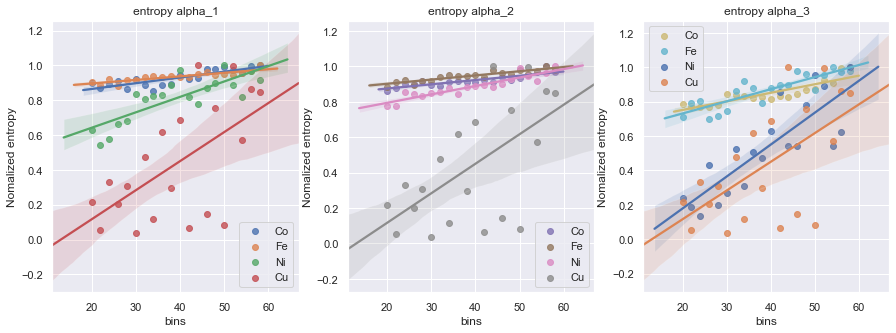

In [173]:
# plot everything
for metric in ['p_wilcox', 'p_ks','intersect','entropy']:
    fig, axs = plt.subplots(ncols=3,figsize=(15,5))
    for i in range(0,3):
        for element in metric_dict_list[i][metric].columns.drop('bins'):
            sns.regplot(data=metric_dict_list[i][metric],x='bins',y=element,label=element,ax=axs[i]).set_title(metric+' alpha_'+str(i+1))
            #axs[i].ylabel("Normalized "+metric)
            axs[i].set(ylabel='Nomalized '+metric)
            axs[i].legend()

### Observations
Based on the changes in statistical metrics with the number of bins in histograms, the p-values from Wilcoxon ranked sum test and the Kolmogorov-Smirnov test are strongly dependent on the number of bins. This makes them an unreliable metric for comparing the different alpha distributions. On the other hand, the intersect is a very strong metric as it is only slightly affected by the bin size. The entropy for most of the systems is also a stong metric, with the exception of Cu for all $\alpha$'s and Ni for the correlation $\alpha$'s.

# Spatial Analysis: bcc Fe

## VESTA Iso-surfaces
To visualize the spatial distribution of $\alpha$'s in Iron, we use VESPA to generate two-dimensional iso surfaces along different planes within the unit cell. VESTA can be tricked into displaying the $\alpha$ values by writing the $\alpha$ values in the form of a formatted electron density file that is compatible with VESTA. 

The lattice planes chose are (100) at 0d and 1d from the origin, (110) at 1d and (111) at 1d. The golden circles represent the position of the atoms in the cell. The iso-surfaces for $\alpha$ values from both RSCAN and PBE calculations are shown. The color scale is consistent across the three $\alpha$ sets for each calculation but not across different planes and functionals. The blue regions of very low, near-zero, $\alpha$'s correspond to the regions close to the atomic positions. In these areas, the pseudopotentials lead to non-physical potentials and some negative $\alpha$ values. 

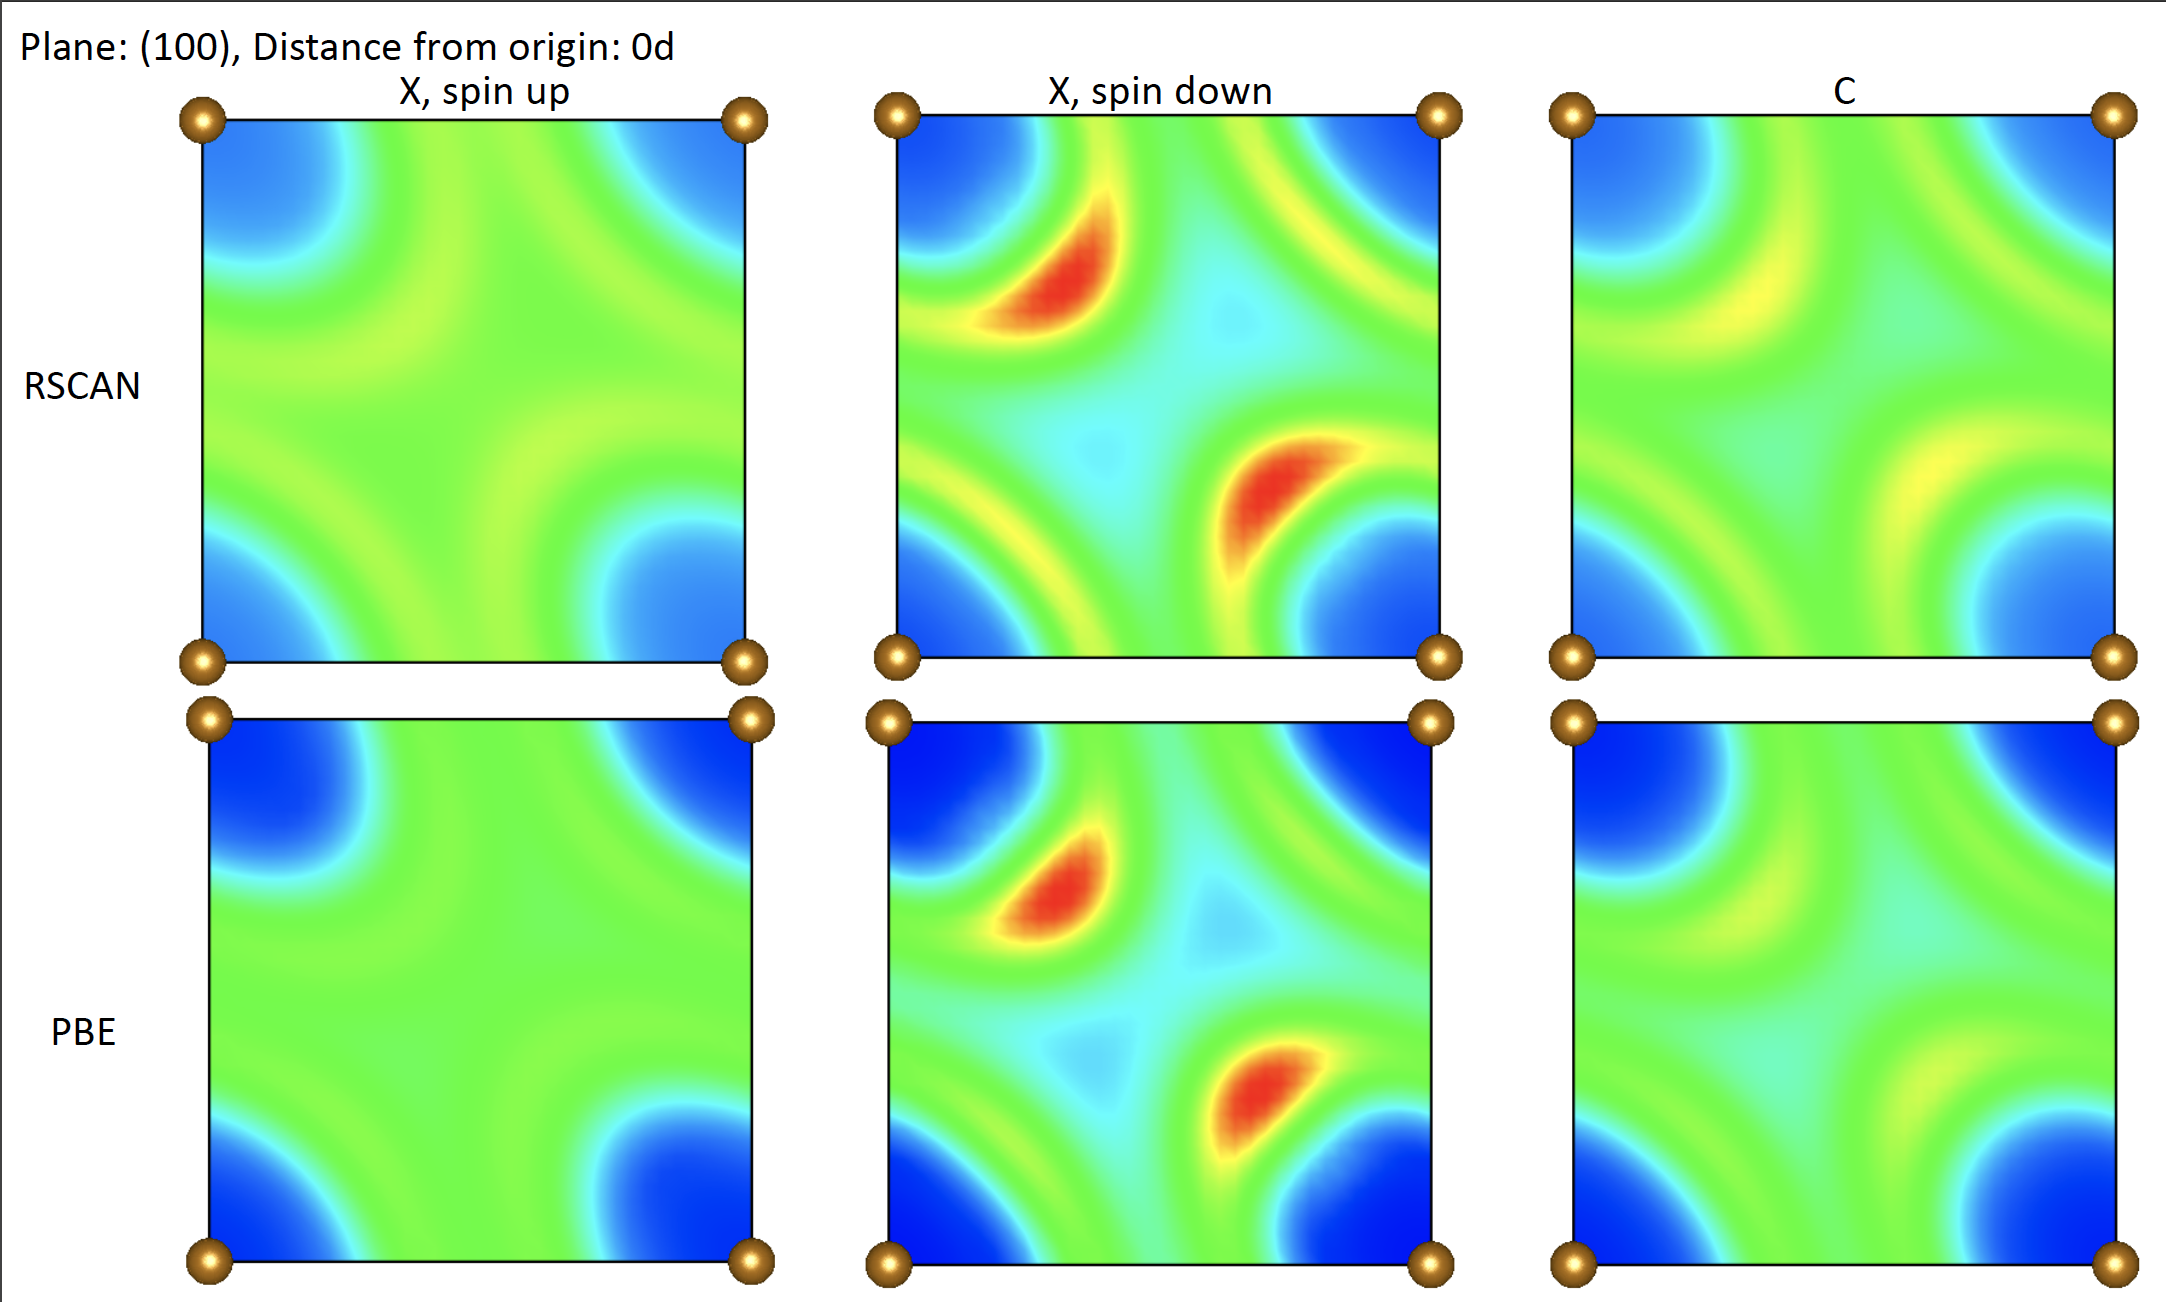

In [102]:
Image(filename = "slices/100_0d.png")

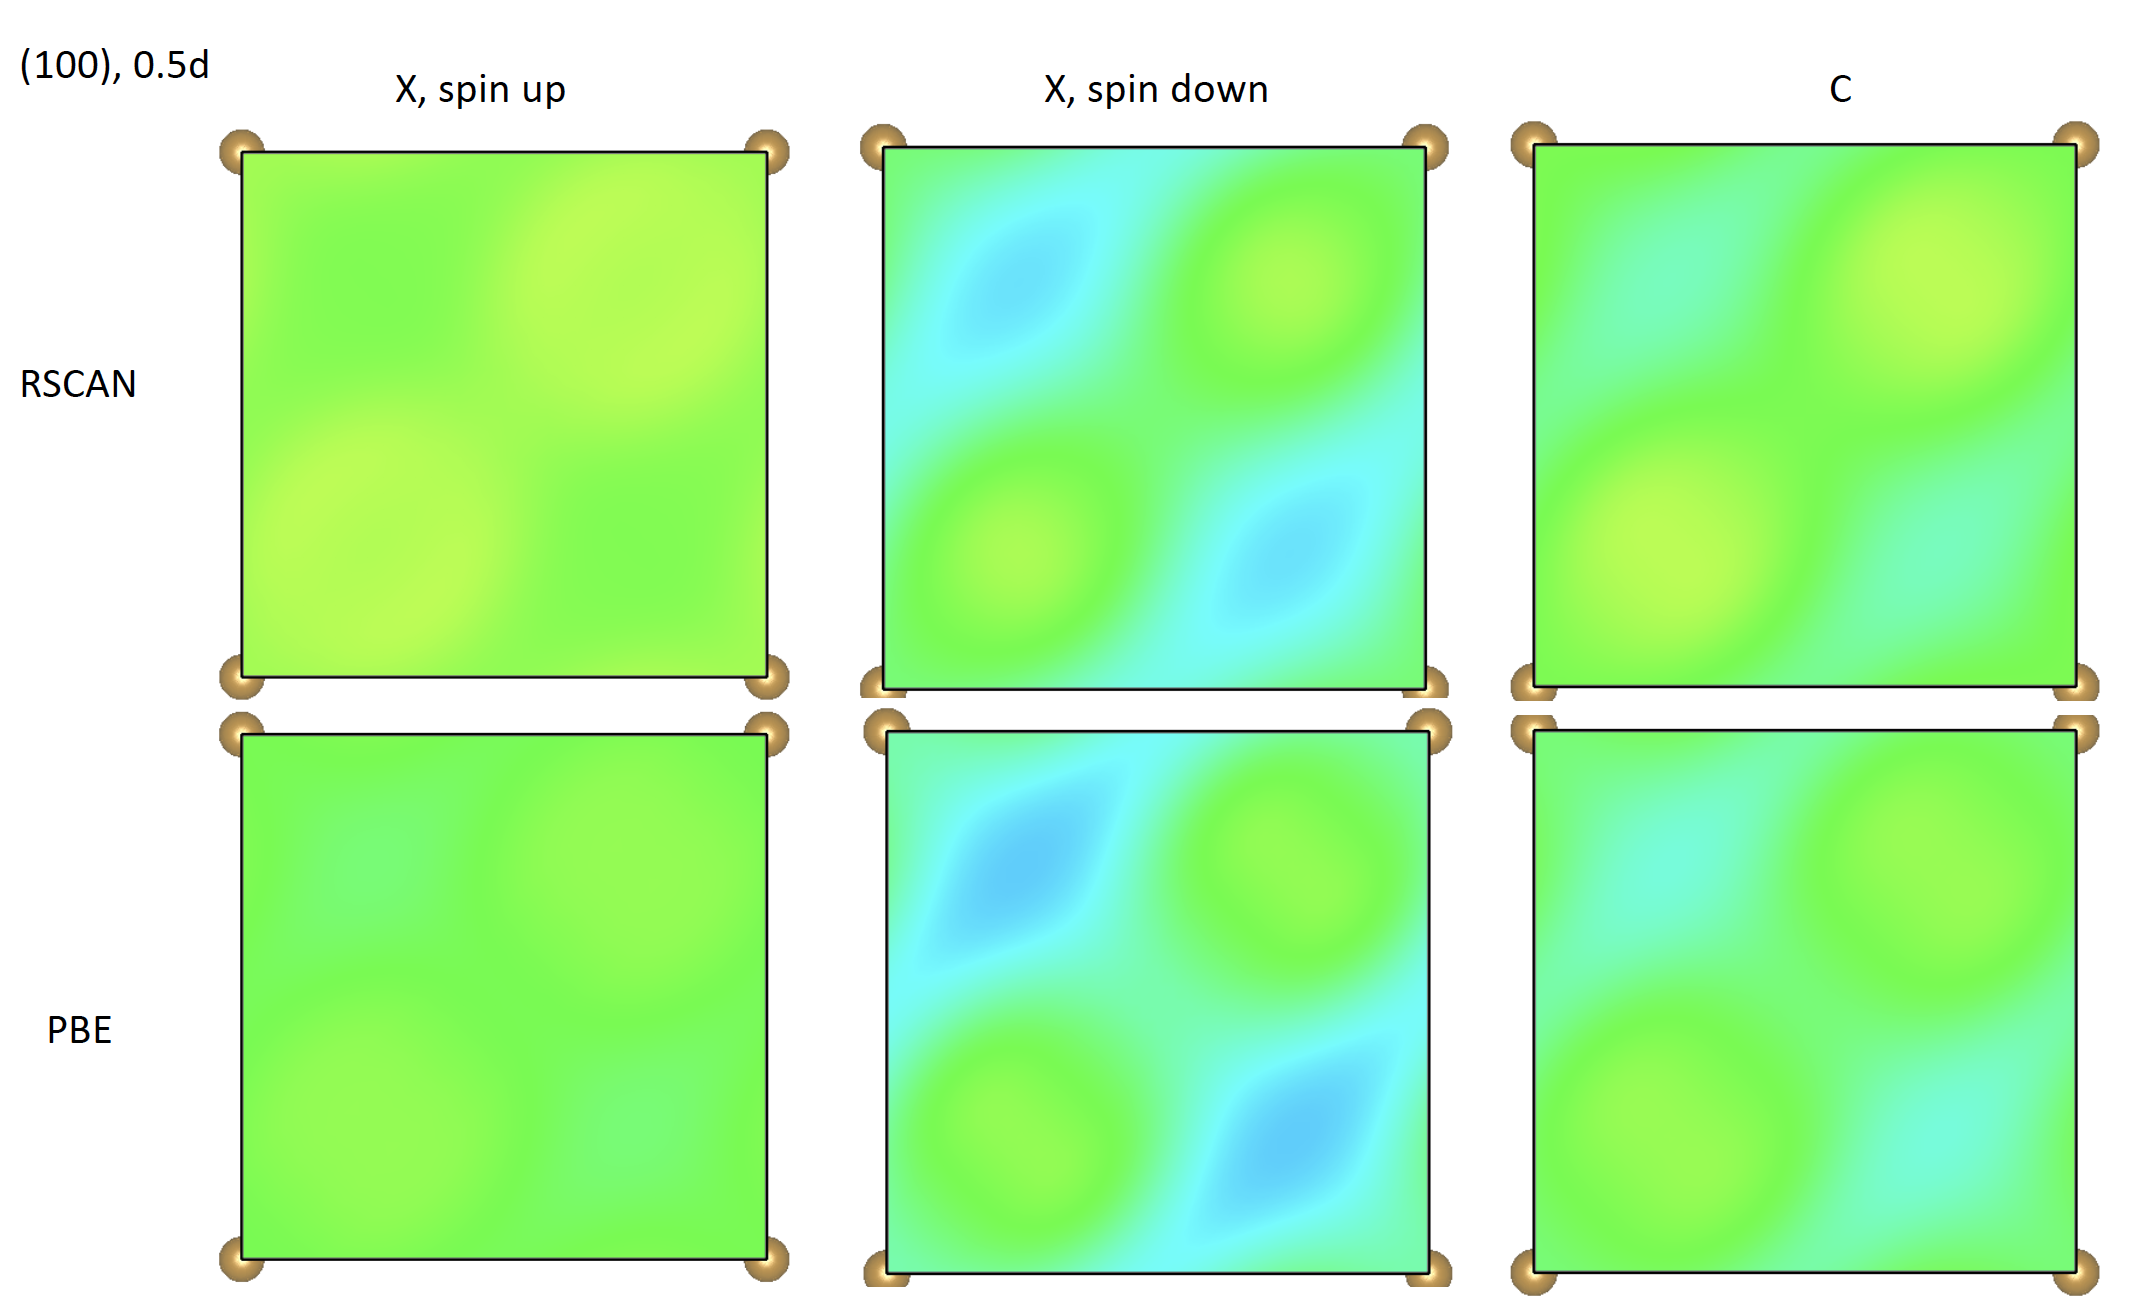

In [104]:
Image(filename = "slices/100_0_5d.png")

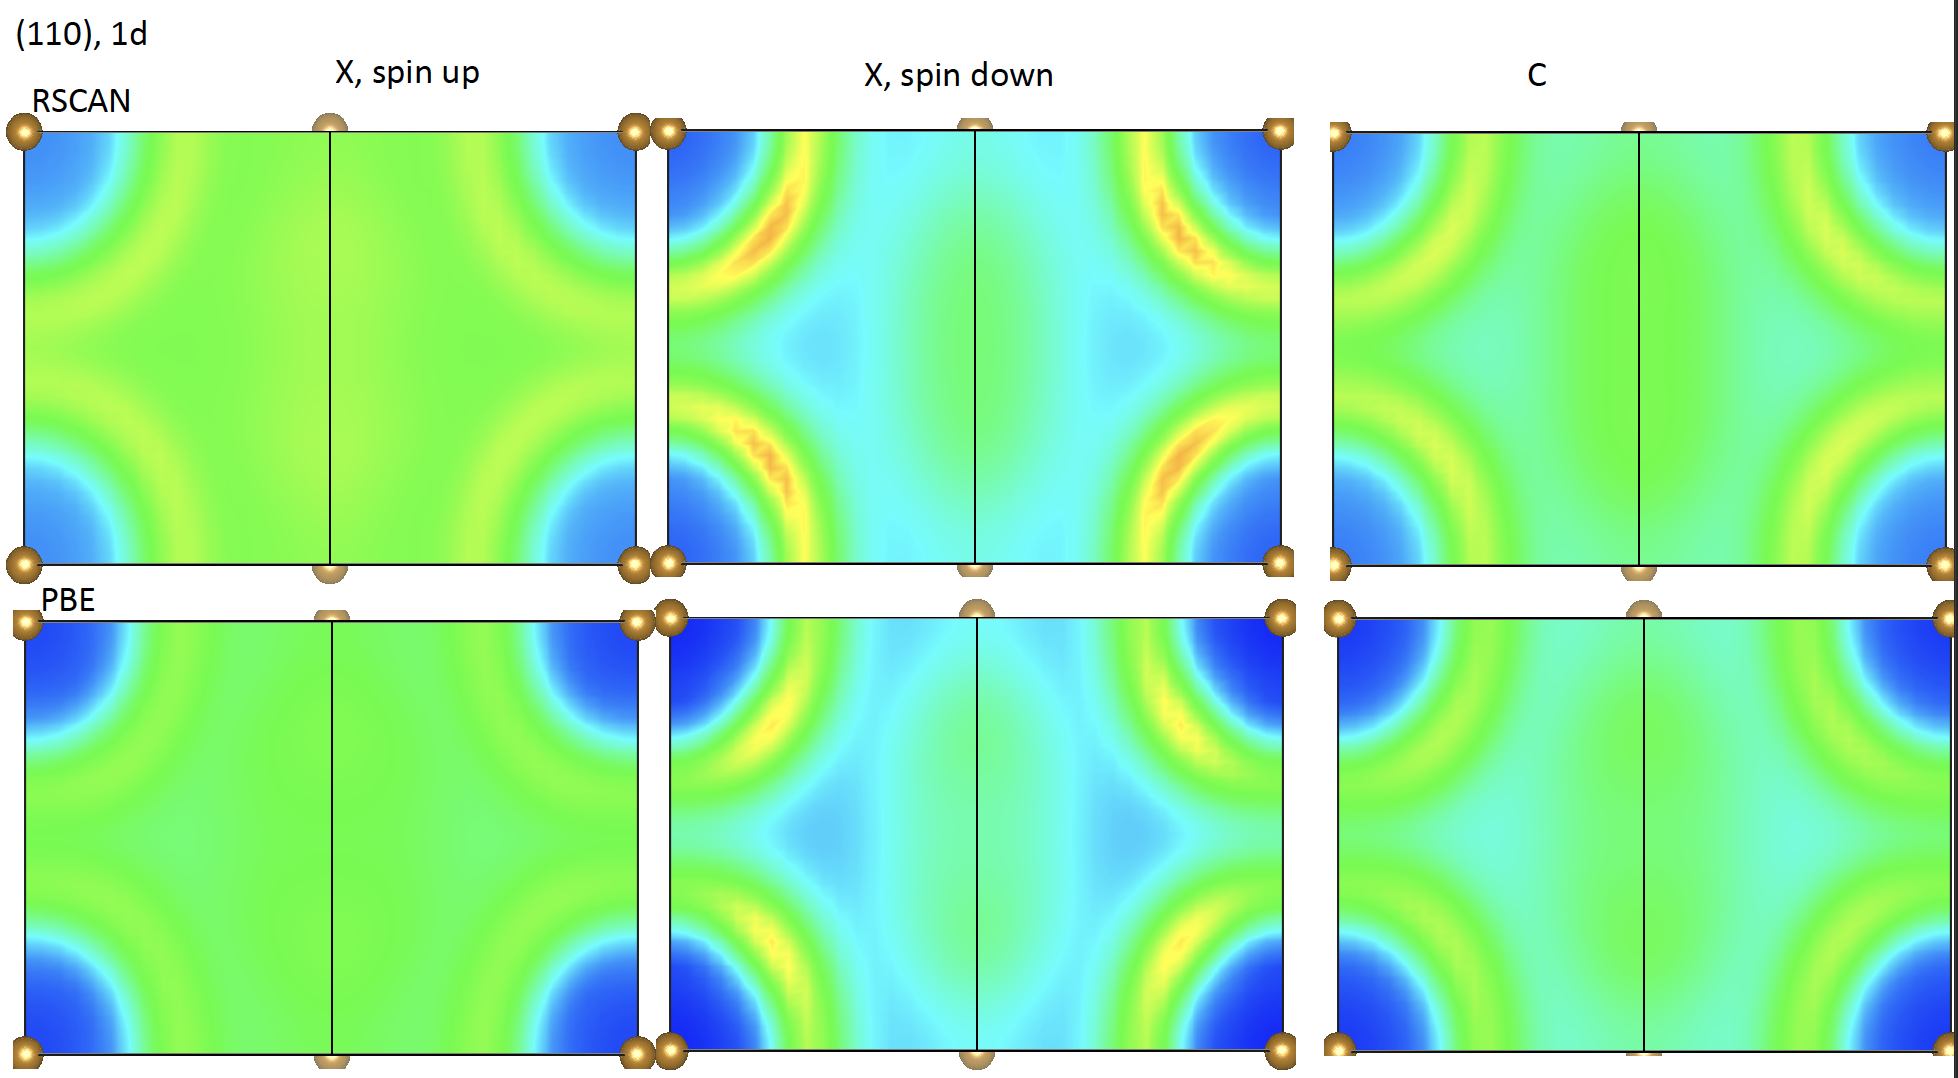

In [106]:
Image(filename = "slices/110_1d.png")

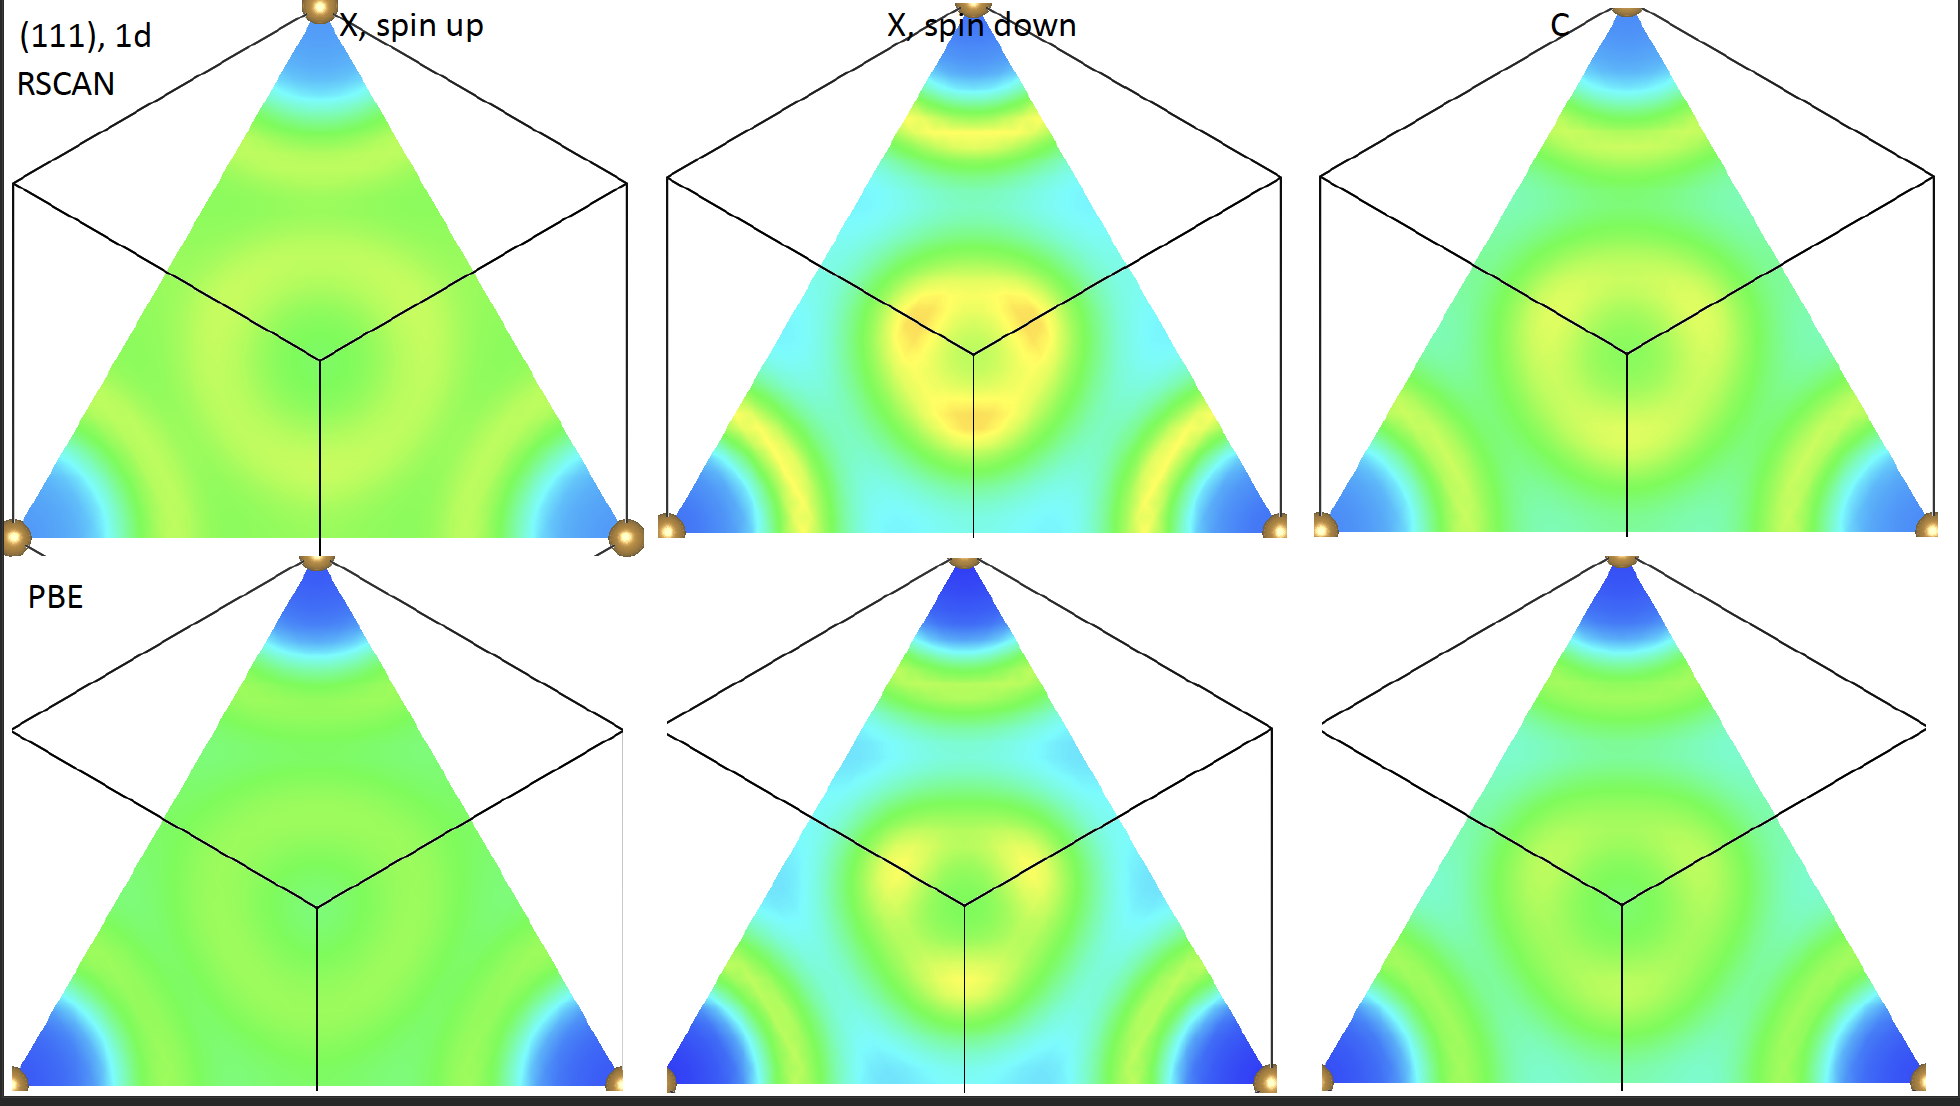

In [110]:
Image(filename = "slices/111_1d.png")

In all of the above iso-surfaces, the spin-down exchange $\alpha$'s show the greatest variation in magnitude. The shapes of the spatial distributions of spin-down exchange $\alpha$ are very similar to those of spin-up exchange and correlation. This is unsurprising as the local binding environment should be the same, irrespective of the exchange or correlation contribution to the functional. Given the clear differences in the $\alpha$ frequency distributions observed earlier, it is clear that despite the similarities in spatial distribution, the values that $\alpha$ takes in the different regions must differ between spin-up/down exchange and correlation. 

The spatial distributions for PBE and RSCAN also follow the same spatial patterns but with slightly different magnitudes of $\alpha$. Due to the inconsistent normalization of the different surfaces, it is difficult to determine any systematic difference between the PBE and RSCAN results. 

## RSCAN vs PBE Custom Heatmaps
To analyze the spatial distribution of $\alpha$ more rigorously, a custom heatmap was designed for two of the iso-surface planes above. The heatmaps for RSCAN and PBE are shown next to one another for each $\alpha$ set and the difference, as well as absolute difference,  are shown. The scale of the heatmap is consistent across all heatmaps for a given plane. 

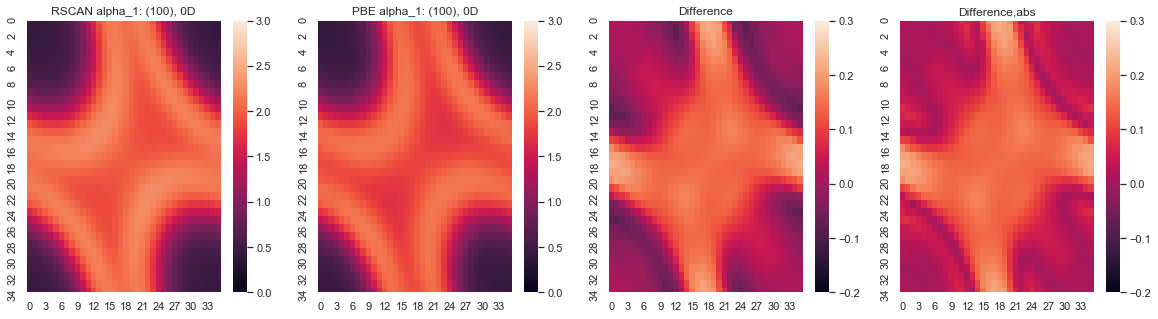

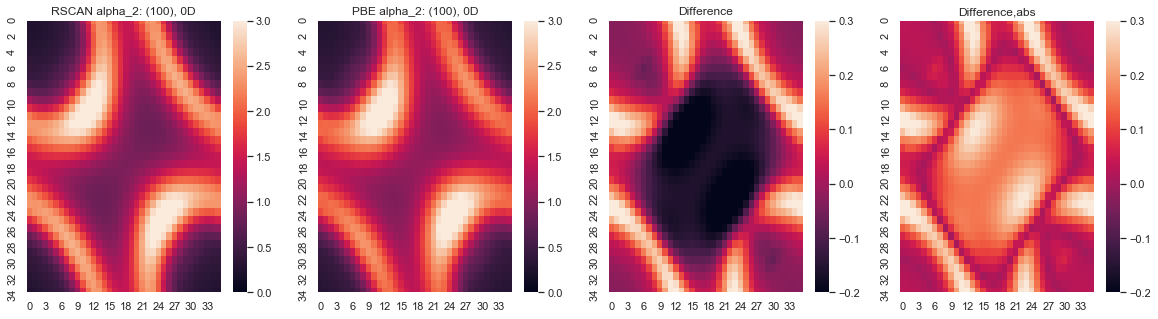

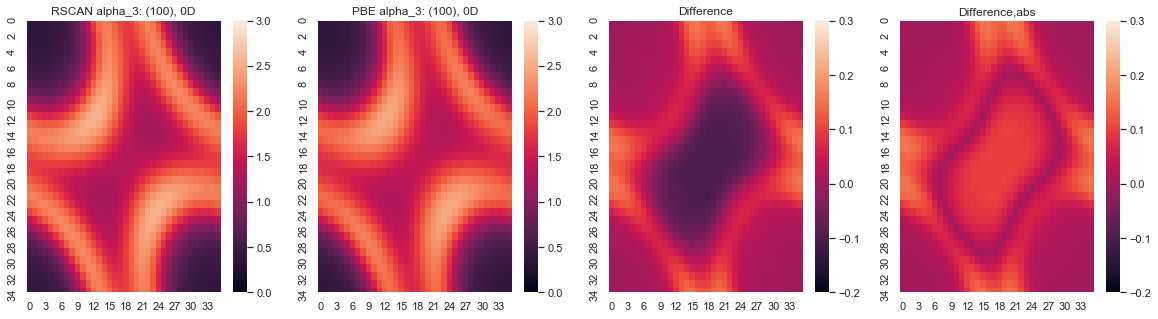

In [182]:
# slice (1,0,0) , Od
for i in range(1,4):
    alpha_slice_1 = spin['Fe']['alpha_'+str(i)][1][0,:,:]
    alpha_slice_2 = spin_pbe['Fe']['alpha_'+str(i)][1][0,:,:]

    plot_heat_triple(alpha_slice_1,alpha_slice_2,labels=['RSCAN alpha_'+str(i),
                'PBE alpha_'+str(i)], set_label='(100), 0D',
                 vmin=0,vmax=3,vmin_diff=-0.2,vmax_diff=0.3)

Visual comparison of the PBE and RSCAN heatmaps for the plane (100) at 0d from the origin shows no differences. The absolute difference shows that the areas around the atoms are in extremely close agreement between PBE and RSCAN. Differences between the two are most pronounced in the central region and narrow shells surrounding the low alpha regions on the atom sites. Overall, the disagreement between RSCAN and PBE is greatest in the spin-down exchange $\alpha$'s as previously hypothesized based on the frequency analysis. The regions of high $\alpha$ appear to differ the most, with relative differences fo about 10%. This explains the different positions of the  $\alpha$ frequency peaks observed previously in Fe. 

The signed differences show that there are areas in which PBE and RSCAN systematically over/under-estimate one another. In the central region RSCAN, $\alpha$'s are smaller than those of PBE for spin-down exchange and correlation. On the other hand, for spin-up exchange, RSCAN $\alpha$'s are larger than those of PBE in his region. This may indicate a difference in which RSCAN and PBE treat the spin-up and spin-down components. 

Below, the heat maps for the plane (100) at 0.5d are shown. Spin-up exchange $\alpha$'s are the highest in this region. Again, the shape of the spatial distribution is the same for PBE and RSCAN with small differences in the values of $\alpha$ in the different regions. As for the previous plane, spin-up exchange tends to be larger in RSCAN but spin-down exchange and correlation tend to be larger in PBE. On average, exchange $\alpha$'s differ more between PBE and RSCAN than correlation $\alpha$'s. 

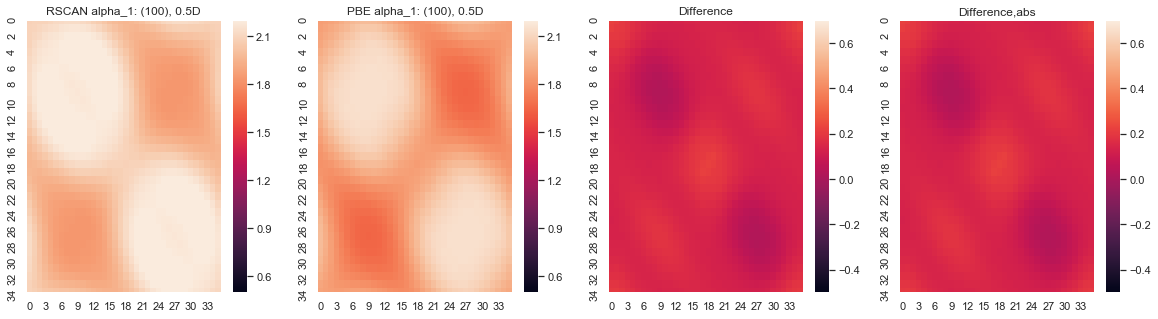

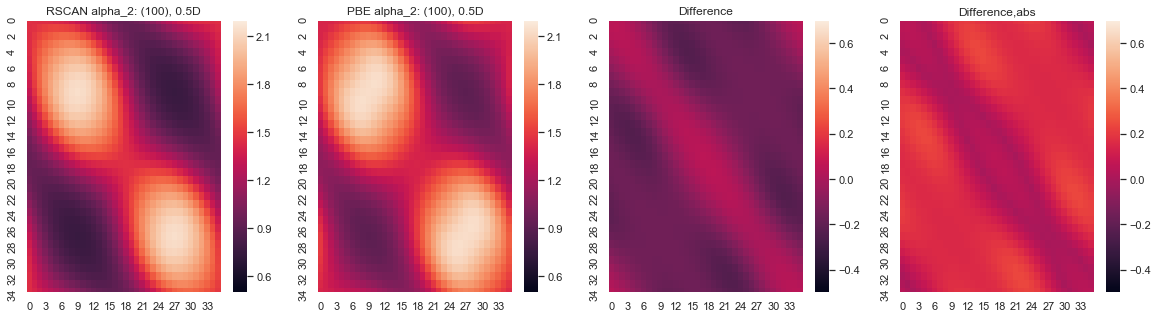

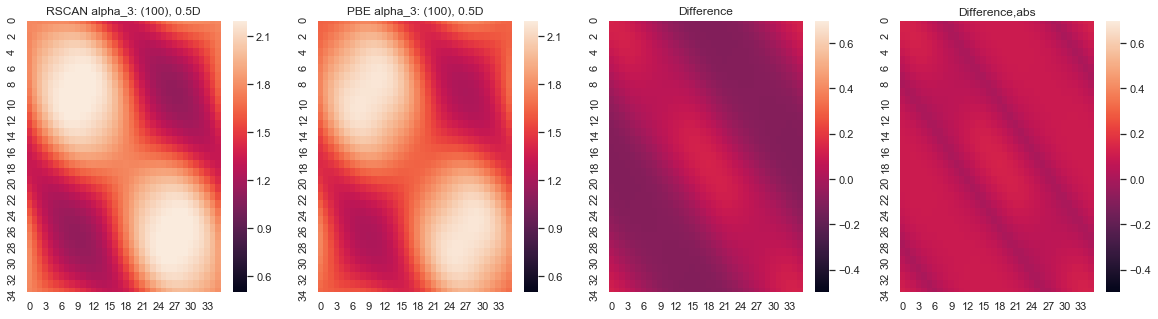

In [112]:
# slice (1,0,0) , O.5d
for i in range(1,4):
    alpha_slice_1 = spin['Fe']['alpha_'+str(i)][1][18,:,:]
    alpha_slice_2 = spin_pbe['Fe']['alpha_'+str(i)][1][18,:,:]

    plot_heat_triple(alpha_slice_1,alpha_slice_2,labels=['RSCAN alpha_'+str(i),
                'PBE alpha_'+str(i)], set_label='(100), 0.5D',
                 vmin=0.5,vmax=2.2, vmin_diff=-0.5,vmax_diff=0.7)

## Spin v.s No_Spin heat maps of 2D slices
To better understand the spatial effects of running a spin-polarized vs non-spin-polarized calculation on iron, two the heatmaps of $\alpha$'s along two planes are shown below. The results confirm that the spin-polarized correlation $\alpha$'s are the closest to the non-spin calculation. Comparing the exchange alpha to the no-spin calculation, the absolute error profile is very similar, but the signed errors are opposite for spin-up and spin-down. The same can be observed for the plane (100) at 0.5d.

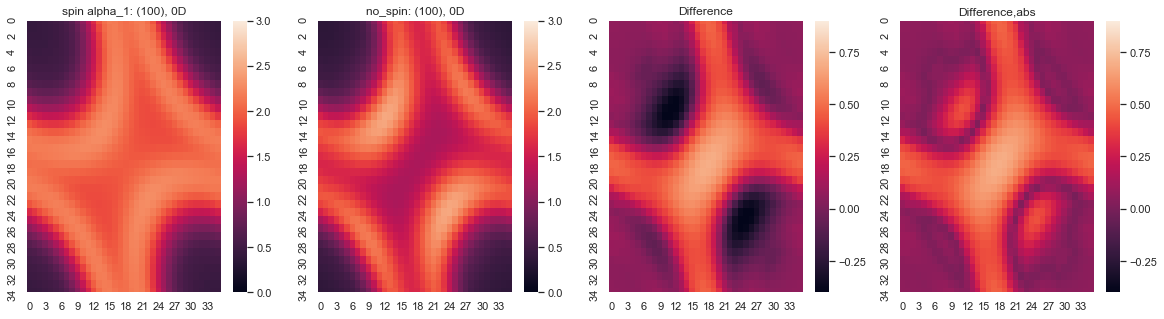

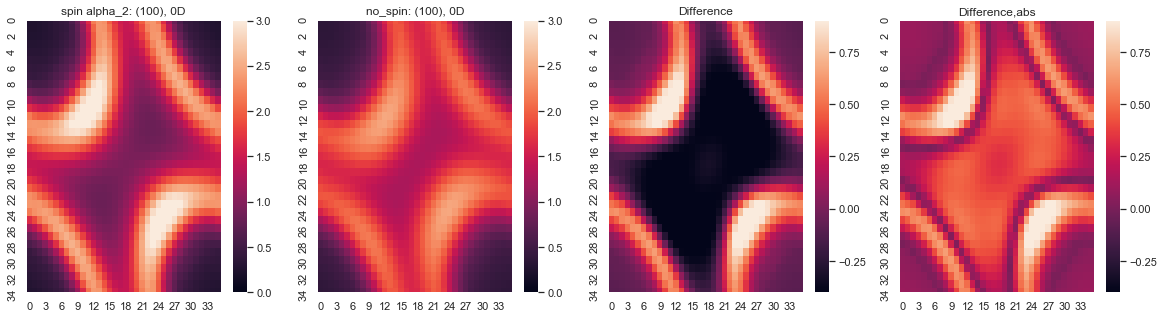

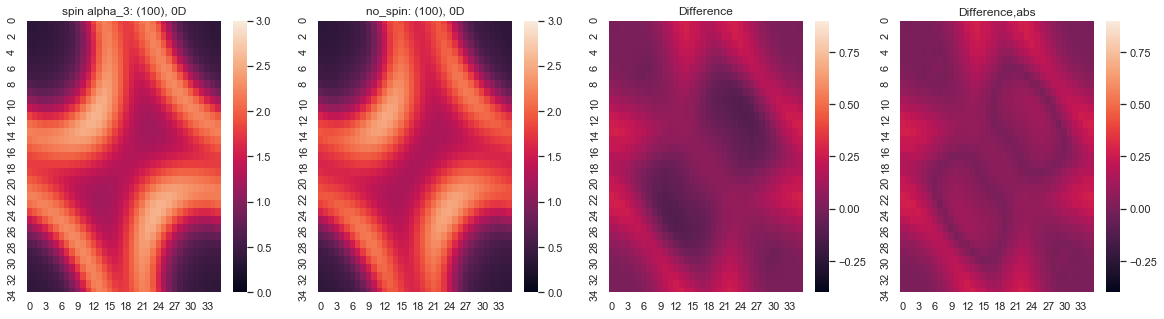

In [180]:
# slice (1,0,0) , Od
for i in range(1,4):
    alpha_slice_1 = spin['Fe']['alpha_'+str(i)][1][0,:,:]
    alpha_slice_2 = no_spin['Fe']['alpha_1'][1][0,:,:]

    plot_heat_triple(alpha_slice_1,alpha_slice_2,labels=['spin alpha_'+str(i),'no_spin'],
                 set_label='(100), 0D',vmin=0,vmax=3,vmin_diff=-0.4,vmax_diff=0.9)


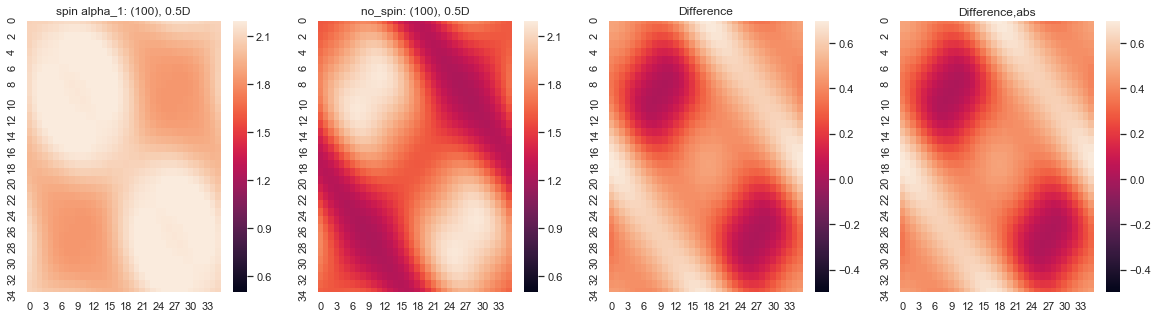

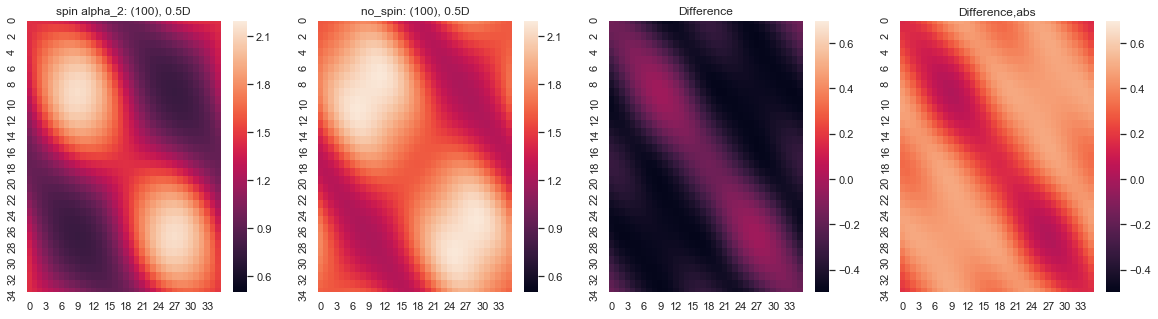

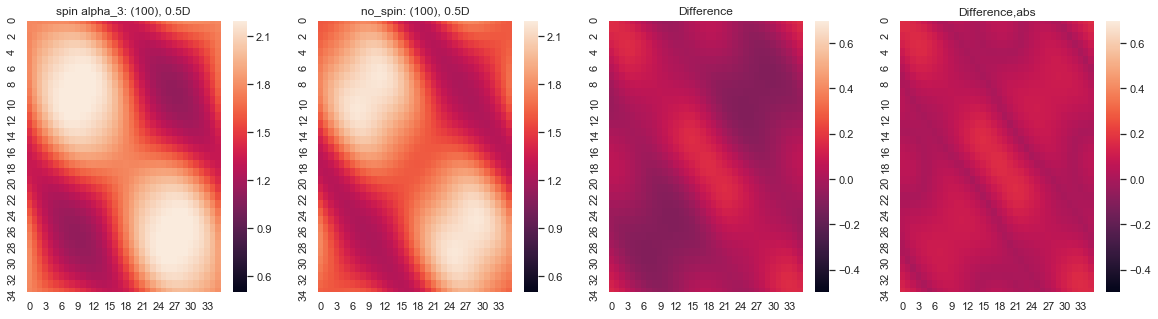

In [181]:
# slice (1,0,0) , 0.5d
for i in range(1,4):
    alpha_slice_1 = spin['Fe']['alpha_'+str(i)][1][18,:,:]
    alpha_slice_2 = no_spin['Fe']['alpha_1'][1][18,:,:]

    plot_heat_triple(alpha_slice_1,alpha_slice_2,labels=['spin alpha_'+str(i),'no_spin'],
                 set_label='(100), 0.5D',vmin=0.5,vmax=2.2, vmin_diff=-0.5,vmax_diff=0.7)

#vmin=0,vmax=3, vmin_diff=-0.4,vmax_diff=0.9

# Conclusion
The above analysis of the $\alpha$ values generated for different materials by both RSCAN and PBE in spin-polarized and spin-unpolarized calculations is an initial exploratory analysis of an extremely large and complex data set. While no definitive answer to the research question can be given, the observations summarized below should inform further analysis and study. 

Based on the frequency distributions, it is clear that the initial hypothesis of high, badly parameterized $\alpha$ values in magnetic materials is false. Many of the spin-unpolarized systems have much higher $\alpha$'s than iron. However, the percentage of $\alpha$'s above 1 is much greater (about 80%) for the spin-polarized systems. Thus, while very large $\alpha$ values cannot explain differences in performance, the larger proportion that lies in the region $\alpha>1$ may do so. Especially the spin-up exchange $\alpha$'s have very few values below 1 and peak sharply at about 2. A thorough analysis of how values in the region  $1<\alpha<3$ effect the switching function and functional form of RSACN would be a natural extension.

The frequency distributions of $\alpha$ are surprisingly representative and it is possible to decern many of the trends observed in spatial analysis from the frequency distributions directly. Thus these should be used as a powerful tool to simplify the three-dimensional data sets. It is very likely, that given the frequency distribution, basic properties of the materials can be guessed. The spin-polarized metals can be clearly distinguished from the insulators and semi-conductors from the frequency distributions alone. By studying a large variety of simple systems, a better understanding could be gained about which features of the frequency distributions indicate which material properties. 

Negative alpha values occur in the regions close to the centers of the atoms. This indicates that they are indeed due to the pseudopotentials. It may be beneficial to force these $\alpha$ values to zero to avoid potential errors caused by unphysical, negative $\alpha$'s.

On the whole, the spatial analysis shows the PBE and RSCAN produce the same spatial patterns but with individual regions at slightly different $\alpha$ values which gives rise to shifted peaks in the frequency distributions. Both the frequency and spatial analysis show that iron and cobalt are more sensitive to changes in functional and spin-polarization settings than the other materials studied. This is especially pronounced in their exchange $\alpha$'s, further indicating that spin plays a crucial role in these systems. Further analysis should be focussed on the exchange $\alpha$'s of iron and cobalt as these show the greatest disagreement with PBE as well as spin-unpolarized calculations on the same systems. The regions in which RSCAN $\alpha$'s are systematically larger or smaller than those of PBE should be considered further, as these regions may illustrate the differences between RSCAN and PBE. 